In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import itertools
import typing

from tqdm import tqdm_notebook

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt



In [ ]:
mae_score = make_scorer(mean_absolute_error,greater_is_better=False)

In [ ]:
import sys
!{sys.executable} -m pip install pmdarima

     |████████████████████████████████| 1.5 MB 6.2 MB/s eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
from pmdarima.arima import auto_arima

# Functions

In [ ]:
def get_season_2yy(df: pd.DataFrame) :
    """
    returns array of ints 
    each maps datetime index on 2-year seasonality period
    6 months frequency
    """
    month = df.index.month - 1
    year = df.index.year 
    period_n = (month / 6).astype('int') + (year % 2) * 2
    return period_n


def get_season_1yy_quater(df: pd.DataFrame):
    """
    returns array of ints 
    each maps datetime index on 1-year seasonality period
    1 quarter frequency
    """
    month = df.index.month
    period_n = ((month - 1)/ 3).astype('int')
    return period_n


def get_season_1yy_month(df: pd.DataFrame):
    """
    returns array of ints 
    each maps datetime index on 1-year seasonality period
    1 month frequency
    """
    month = df.index.month
    period_n = month % 12
    return period_n


def get_season_1yy_week(df: pd.DataFrame):
    """
    returns array of ints 
    each maps datetime index on 1-year seasonality period
    1 week frequency
    """
    week = df.index.week
    period_n = week % 52
    return period_n

def get_season_1d_week(df: pd.DataFrame):
    """
    returns array of ints 
    each maps datetime index on 1-week seasonality period
    1 day frequency
    """
    unix_sec = df.index.astype(int) / 10**9
    day = (unix_sec / 60 / 60 / 24).astype(int)
    period_n = day % 7
    return period_n


def get_season_1h_day(df: pd.DataFrame):
    """
    returns array of ints 
    each maps datetime index on 1-day seasonality period
    1 hour frequency
    """
    hour = df.index.hour
    period_n = hour % 24
    return period_n

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):  
    mask = y_true != 0
    return (np.fabs(y_true[mask] - y_pred[mask])/y_true[mask]).mean()

In [ ]:
def prep_y(y: typing.Union[pd.DataFrame, pd.Series, np.array]) -> np.array:
    if isinstance(y, pd.DataFrame):
        y = y.iloc[:, 0].values
    if isinstance(y, pd.Series):
        y = y.values
    return y.flatten()

def get_metric_report(
    y_train_hat: typing.Union[pd.DataFrame, pd.Series, np.array], 
    y_train:  typing.Union[pd.DataFrame, pd.Series, np.array], 
    y_test_hat:  typing.Union[pd.DataFrame, pd.Series, np.array], 
    y_test:  typing.Union[pd.DataFrame, pd.Series, np.array]
):
    """
    Prints MAE and MAPE for predictions on train and test
    """
    y_train_hat = prep_y(y_train_hat)
    y_train = prep_y(y_train)
    y_test_hat = prep_y(y_test_hat)
    y_test = prep_y(y_test)

    mape = mean_absolute_percentage_error(y_train_hat, y_train)
    mae = mean_absolute_error(y_train_hat, y_train)

    print("Train error")
    print("\tMAPE = %6.2f"%(mape))
    print("\tMSE = %6.2f"%(mae))

    mape = mean_absolute_percentage_error(y_test_hat, y_test)
    mae = mean_absolute_error(y_test_hat, y_test)

    print("Test error")
    print("\tMAPE = %6.2f"%(mape))
    print("\tMAE = %6.2f"%(mae))

In [ ]:
def get_residuals(
    df: pd.DataFrame, 
    col_old: str,
    col_new: str, 
    col_rem: str    
) -> pd.DataFrame:
    """
    saves col_new to col_old
    and updates col_new
    """
    df[col_old] = df[col_new].copy()
    df[col_new] = (df[col_old] - df[col_rem])
    
    return df

def add_seasonal_comp(
    df: pd.DataFrame, 
    df_seasonality: pd.DataFrame,
    name: str, 
    fun_seas: typing.Callable[[pd.DataFrame], typing.List[int]], 
    col_seasonal: str='resid', 
    df_test: pd.DataFrame=None, 
    update_col_seasonal: bool=True, 
) -> (pd.DataFrame, pd.DataFrame):
    """
    calculates seasonal component defined by fun_seas
    for df[name]
    if needed adds the same components for df_test
    and computes residuals 
    between old column df[name] and new column df[{name}_vals]
    """
    name_vals = f"{name}_vals"
        
    # mark each index with component number
    df[name] = fun_seas(df)
    df_seasonality[name] = fun_seas(df_seasonality)
    # compute values of seasonal components
    seas_vals = df_seasonality.groupby(name)[['seasonal']].mean().reset_index().rename(columns={'seasonal': name_vals})
#     seas_vals = df.loc[mask].groupby(name)[[col_seasonal]].mean().reset_index().rename(columns={col_seasonal: name_vals})
    df[name_vals] = df.merge(seas_vals, on=name, how='left')[name_vals].values
    
    # update df_test
    if df_test is None:
        pass
    else:
        df_test[name] = fun_seas(df_test)
        df_test[name_vals] = df_test.merge(seas_vals, on=name, how='left')[name_vals].values
    
    # find residuals
    if update_col_seasonal:
        col_seas_old = f"{col_seasonal}_before_{name}"
        df = get_residuals(df, col_seas_old, col_seasonal, name_vals)
        
        if df_test is None:
            pass
        else:
            df_test = get_residuals(df_test, col_seas_old, col_seasonal, name_vals)
            
    return df, df_test

In [ ]:
def plot_seasonalty(
    df_seasonality: pd.DataFrame, 
    check_periods: typing.List[int]
) -> typing.Dict[str, pd.DataFrame]:
    """
    for each period in check_periods 
    aggregates data considering period as seasonality cycle
    and plots the result
    
    returns dictionary of calculates statistics for each aggregation:
    mean, min, max value for each season
    """
    df_seasonality_stat_dict = dict()
    min_month = df_seasonality.index[0].month

    for period in check_periods:
        df_seasonality.loc[:, 'season'] = (np.arange(df_seasonality.shape[0]) + min_month) % period + 1

        plt.style.use('seaborn')
        funs_agg = ['mean', 'min', 'max']
        df_seasonality_stat = df_seasonality.groupby("season").agg({'seasonal': funs_agg})
        df_seasonality_stat.columns = funs_agg
        plt.plot(df_seasonality_stat['mean'], color="orange", label="mean")
        plt.fill_between(
            df_seasonality_stat.index, 
            df_seasonality_stat['min'], 
            df_seasonality_stat['max'], 
            alpha=0.3,
            color='grey',
            label='min-max area'
        )
        plt.legend()
        plt.title(f'Seasonality components with period = {period}');
        plt.show();
        df_seasonality_stat_dict[period] = df_seasonality_stat
        
    return df_seasonality_stat_dict

In [ ]:
def resample_resid(resid_vals: pd.DataFrame, make_plot: bool=True)  -> typing.Dict[str, pd.DataFrame]:
    """
    resample data and plot them
    """
    resid_vals_prep = resid_vals.resample('1h').mean()
    
    fill_nan_ma = resid_vals_prep.rolling(window=3, center=True, min_periods=1).mean()
    indx_na = resid_vals_prep.isna()
    resid_vals_prep.loc[indx_na] = fill_nan_ma.loc[indx_na]
    
    resid_resampled = dict()
    resid_resampled['raw'] = resid_vals_prep
    
    resid_resampled['daily'] = resid_vals_prep.resample('1d').mean()
    resid_resampled['weekly'] = resid_vals_prep.resample('1w').mean()
    resid_resampled['monthly'] = resid_vals_prep.resample('1m').mean()
    resid_resampled['quaterly'] = resid_vals_prep.resample('3m').mean()
    resid_resampled['half-yearly'] = resid_vals_prep.resample('6m').mean()
    
    if make_plot:
        for name, vals in resid_resampled.items():
            plt.plot(vals)
            plt.title(name)
            plt.show()
        
    return resid_resampled

In [ ]:
def plot_seasonal_component(
    df_train: pd.DataFrame, 
    df_test: pd.DataFrame, 
    col_seas: str, 
    timedelta: pd.Timedelta=None):
    """
    plots values of col_seas for train and test dataframes
    if needed filters data using timedelta
    last periods for train
    first periods for test
    """
    last_date = df_train.index.max()
    
    if timedelta is None:
        df_train_filtered = df_train
        df_test_filtered = df_test
    else:
        ind_filter_train = df_train.index > (last_date - timedelta)
        ind_filter_test = df_test.index < (last_date + timedelta)
        df_train_filtered = df_train.loc[ind_filter_train]
        df_test_filtered = df_test.loc[ind_filter_test]

    plt.figure(figsize=(14, 4))
    plt.plot(df_train_filtered[col_seas], label='train');
    plt.plot(df_test_filtered[col_seas], label='test');
    plt.title(f'{col_seas} seasonality component')
    plt.legend()
    plt.show()

# Load data

In [ ]:
df = pd.read_csv('../input/hourly-energy-consumption/DUQ_hourly.csv',
                   index_col=[0], parse_dates=[0])

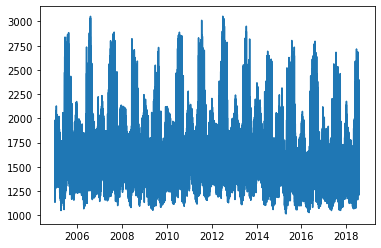

In [ ]:
plt.plot(df)

# 1. Simple regression method

In [ ]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour

In [ ]:
df.head()

DUQ_MW  year  month  day  hour
Datetime                                           
2005-12-31 01:00:00  1458.0  2005     12   31     1
2005-12-31 02:00:00  1377.0  2005     12   31     2
2005-12-31 03:00:00  1351.0  2005     12   31     3
2005-12-31 04:00:00  1336.0  2005     12   31     4
2005-12-31 05:00:00  1356.0  2005     12   31     5

In [ ]:
df.sort_index(inplace=True)

In [ ]:
df.shape

(119068, 5)

Leave one year to check forecasting

In [ ]:
indx_test = df.index > (df.index.max() - pd.Timedelta('1y'))

In [ ]:
df_test = df.loc[indx_test].copy(deep=True)
df_train = df.loc[~indx_test].copy(deep=True)

print(f"For training: {df_train.shape[0]}")
print(f"For test: {df_test.shape[0]}")

For training: 110302
For test: 8766


In [ ]:
X_train = df_train[['year', 'month', 'day', 'hour']]
y_train = df_train[['DUQ_MW']]

X_test = df_test[['year', 'month', 'day', 'hour']]
y_test = df_test[['DUQ_MW']]

X = df[['year', 'month', 'day', 'hour']]
y = df[['DUQ_MW']]

In [ ]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('lm', LinearRegression())])
cv_ts = TimeSeriesSplit(n_splits=7)
cross_val_score(pipe, X_train, y_train, cv=cv_ts)

array([0.19885694, 0.17438805, 0.20623651, 0.18967571, 0.2195586 ,
       0.19615918, 0.10444521])

In [ ]:
pipe.fit(X_train, y_train);
model = pipe.named_steps['lm']
pd.DataFrame(model.coef_, columns=X_train.columns)

year      month       day        hour
0 -76.433179 -15.335834 -2.815719  482.327057

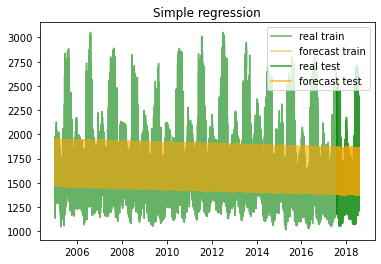

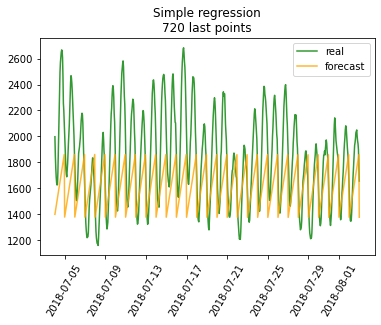

In [ ]:
plt.plot(y_train, label='real train', color='green', alpha=0.6)
plt.plot(y_train.index, pipe.predict(X_train), label='forecast train', color='orange', alpha=0.6)
plt.plot(y_test, label='real test', color='green', alpha=0.8)
plt.plot(y_test.index, pipe.predict(X_test), label='forecast test', color='orange', alpha=0.8)
plt.legend();
plt.title('Simple regression');
plt.show()

k = 24 * 30 # month
plt.plot(y_test.iloc[-k:], label='real', color='green', alpha=0.8)
plt.plot(y_test.index[-k:], pipe.predict(X_test)[-k:], label='forecast', color='orange', alpha=0.8)
plt.legend();
plt.title('Simple regression' + f"\n{k} last points");
plt.xticks(rotation=60);
plt.show();

In [ ]:
y_hat_train = pipe.predict(X_train)
y_hat_test = pipe.predict(X_test)
get_metric_report(y_hat_train, y_train, y_hat_test, y_test)

Train error
	MAPE =   0.12
	MSE = 202.04
Test error
	MAPE =   0.12
	MAE = 197.67


# 2. Regression + seasonal and trend features
Decompose series to get additional features

## 2.1 Data preparation for decomposition

In [ ]:
y_train_prep = y_train.resample('1h').mean()

In [ ]:
y_train_prep.loc[y_train_prep.iloc[:, 0].isna()].head()

DUQ_MW
Datetime                   
2005-04-03 03:00:00     NaN
2005-10-30 02:00:00     NaN
2006-04-02 03:00:00     NaN
2006-10-29 02:00:00     NaN
2007-03-11 03:00:00     NaN

#### Fill missing values with rolling mean

In [ ]:
fill_nan_ma = y_train_prep.rolling(window=3, center=True, min_periods=1).mean()
indx_na = y_train_prep.iloc[:, 0].isna()
y_train_prep.loc[indx_na] = fill_nan_ma.loc[indx_na]

In [ ]:
y_train_prep.loc[y_train_prep.iloc[:, 0].isna()].head()

Empty DataFrame
Columns: [DUQ_MW]
Index: []

## 2.2 Decomposition of series

### 2.2.1 Check raw data decomposition

In [ ]:
result = seasonal_decompose(y_train_prep, model='additive')

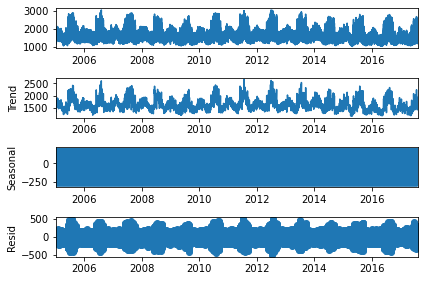

In [ ]:
result.plot();

### 2.2.2 Check decomposition of resampled data 

Lets first find some high-level seasonalities

In [ ]:
y_resampled = dict()
y_resampled['daily'] = y_train_prep.resample('1d').mean()
y_resampled['weekly'] = y_train_prep.resample('1w').mean()
y_resampled['monthly'] = y_train_prep.resample('1m').mean()
y_resampled['quaterly'] = y_train_prep.resample('3m').mean()
y_resampled['half-yearly'] = y_train_prep.resample('6m').mean()
y_resampled['yearly'] = y_train_prep.resample('1y').mean()

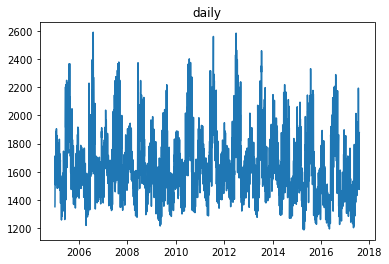

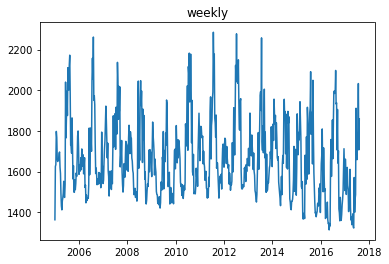

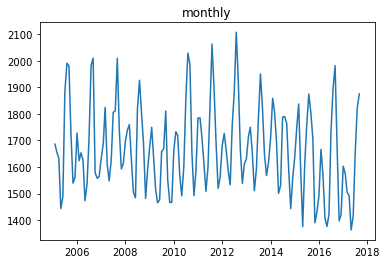

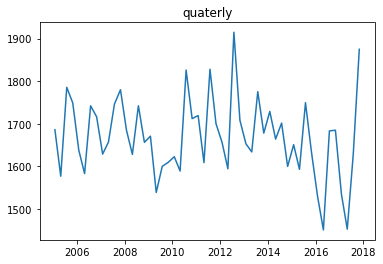

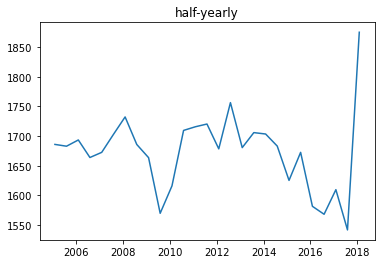

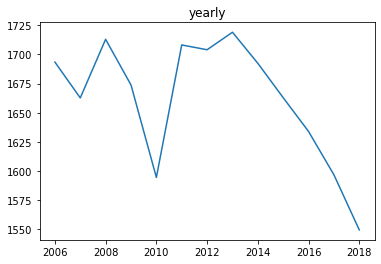

In [ ]:
for name, vals in y_resampled.items():
    plt.plot(vals)
    plt.title(name)
    plt.show()

## 2.3 Add seasonality features

### 2.3.1 Half-year resampled data

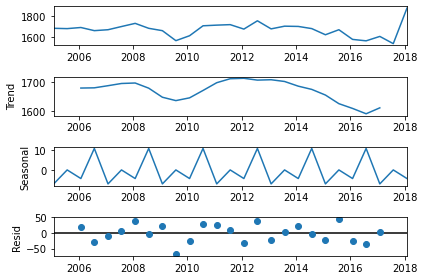

In [ ]:
result = seasonal_decompose(y_resampled['half-yearly'], model='additive')
result.plot();

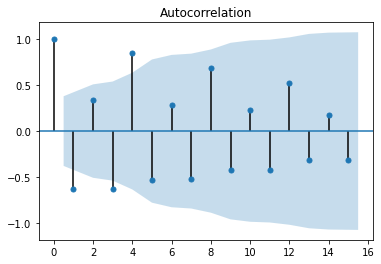

In [ ]:
df_seasonality = result.seasonal.to_frame()
plot_acf(df_seasonality);

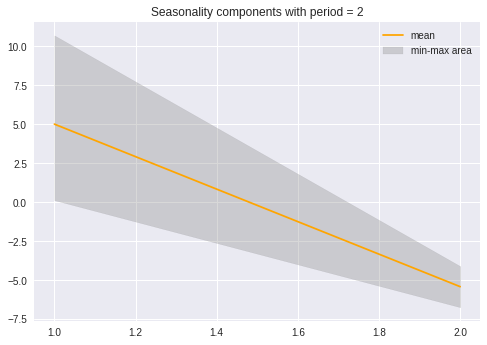

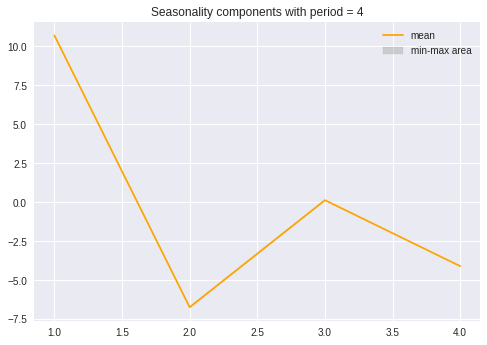

In [ ]:
plot_seasonalty(df_seasonality, [2, 4]);

In future we will find components in residuals, so lets at first step copy target values in resid column

In [ ]:
df_train['resid'] = df_train['DUQ_MW'].copy(deep=True)
df_test['resid'] = df_test['DUQ_MW'].copy(deep=True)

In [ ]:
col_seas = 'seas_6m_2yy'
col_seas_vals = f"{col_seas}_vals"

In [ ]:
df_train, df_test = add_seasonal_comp(df_train, df_seasonality, col_seas, get_season_2yy, 'resid', df_test)

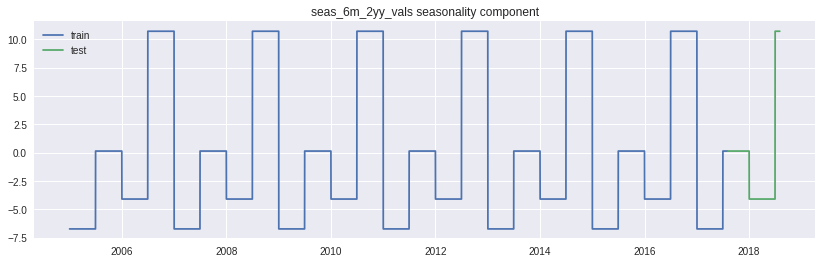

In [ ]:
plot_seasonal_component(df_train, df_test, col_seas_vals)

In [ ]:
df_train

DUQ_MW  year  month  day  hour        resid  seas_6m_2yy  \
Datetime                                                                        
2005-01-01 01:00:00  1364.0  2005      1    1     1  1370.736504            2   
2005-01-01 02:00:00  1273.0  2005      1    1     2  1279.736504            2   
2005-01-01 03:00:00  1218.0  2005      1    1     3  1224.736504            2   
2005-01-01 04:00:00  1170.0  2005      1    1     4  1176.736504            2   
2005-01-01 05:00:00  1166.0  2005      1    1     5  1172.736504            2   
...                     ...   ...    ...  ...   ...          ...          ...   
2017-08-02 14:00:00  2288.0  2017      8    2    14  2287.866904            3   
2017-08-02 15:00:00  2353.0  2017      8    2    15  2352.866904            3   
2017-08-02 16:00:00  2403.0  2017      8    2    16  2402.866904            3   
2017-08-02 17:00:00  2430.0  2017      8    2    17  2429.866904            3   
2017-08-02 18:00:00  2389.0  2017      8    2    18  2388.866904            3   

                     seas_6m_2yy_vals  resid_before_seas_6m_2yy  
Datetime                                                         
2005-01-01 01:00:00         -6.736504                    1364.0  
2005-01-01 02:00:00         -6.736504                    1273.0  
2005-01-01 03:00:00         -6.736504                    1218.0  
2005-01-01 04:00:00         -6.736504                    1170.0  
2005-01-01 05:00:00         -6.736504                    1166.0  
...                               ...                       ...  
2017-08-02 14:00:00          0.133096                    2288.0  
2017-08-02 15:00:00          0.133096                    2353.0  
2017-08-02 16:00:00          0.133096                    2403.0  
2017-08-02 17:00:00          0.133096                    2430.0  
2017-08-02 18:00:00          0.133096                    2389.0  

[110302 rows x 9 columns]

Resample again

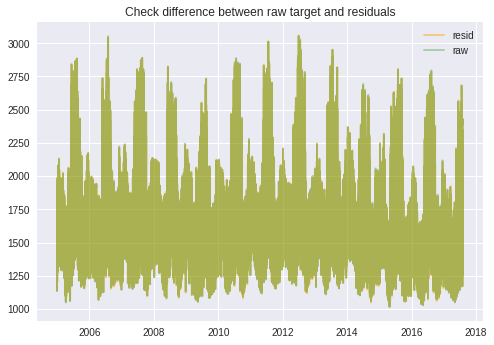

In [ ]:
plt.plot(df_train['resid'], alpha=0.5, label='resid', color='orange')
plt.plot(df_train['DUQ_MW'], alpha=0.3, label='raw', color='green')
plt.legend();
plt.title("Check difference between raw target and residuals");

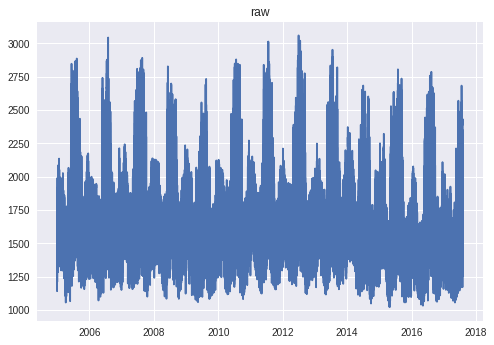

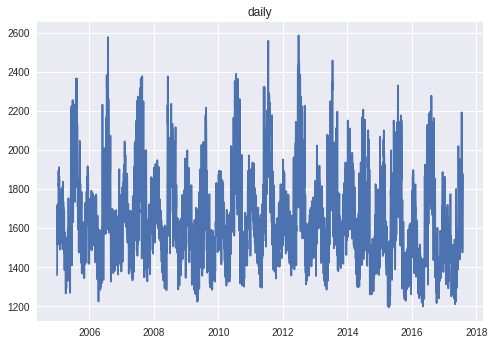

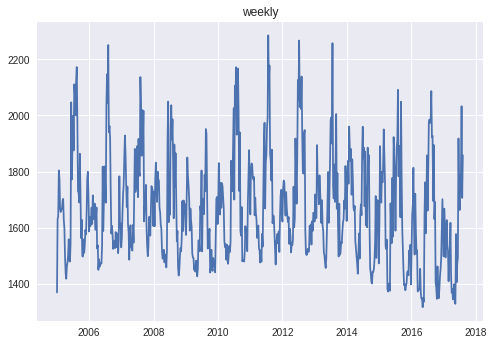

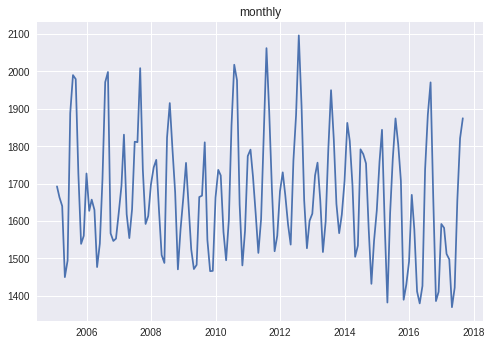

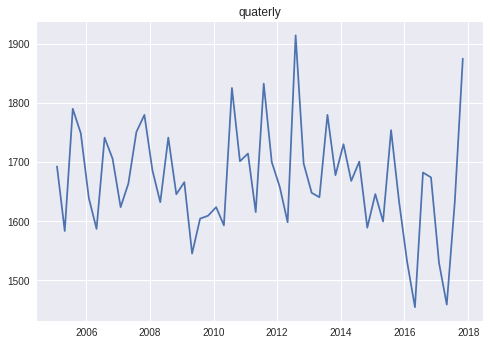

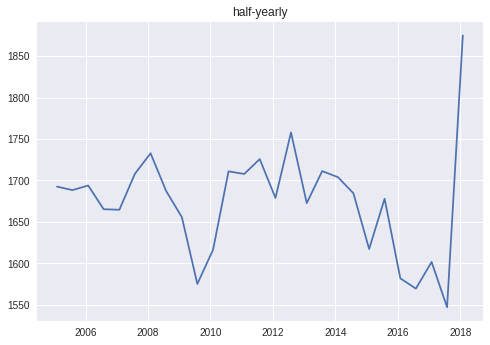

In [ ]:
resid_resampled = resample_resid(df_train['resid'])

### 2.3.2 Quater resampled data

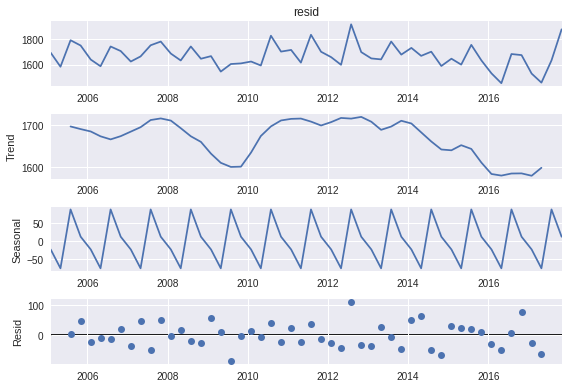

In [ ]:
result = seasonal_decompose(resid_resampled['quaterly'], model='additive')
result.plot();

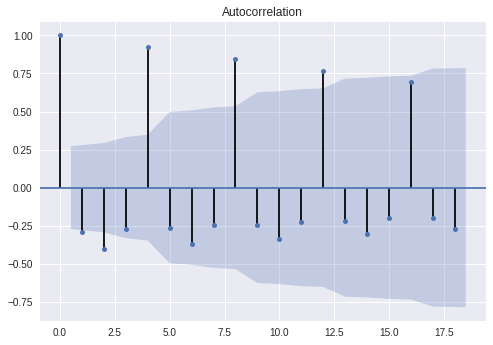

In [ ]:
df_seasonality = result.seasonal.to_frame()
plot_acf(df_seasonality);

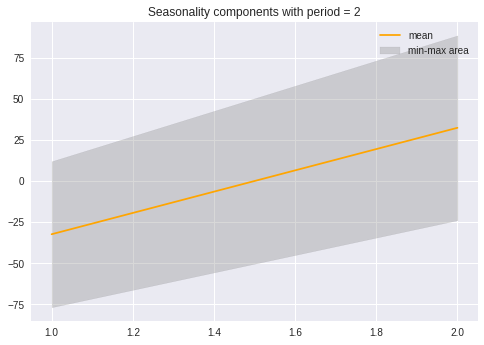

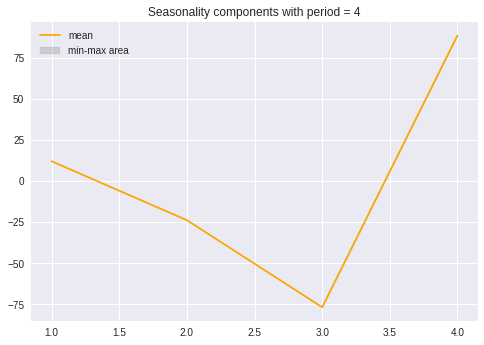

In [ ]:
plot_seasonalty(df_seasonality, [2, 4]);

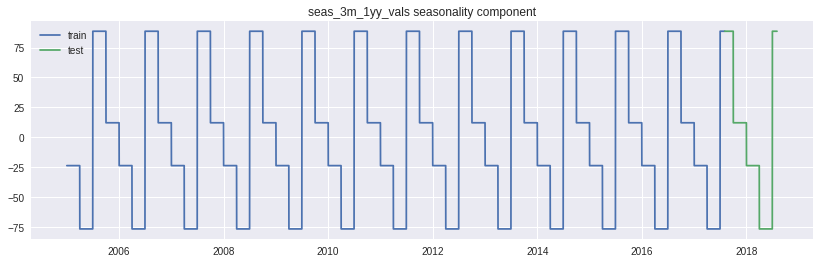

In [ ]:
col_seas = 'seas_3m_1yy'
col_seas_vals = f"{col_seas}_vals"

df_train, df_test = add_seasonal_comp(df_train, df_seasonality, col_seas, get_season_1yy_quater, 'resid', df_test)
plot_seasonal_component(df_train, df_test, col_seas_vals)

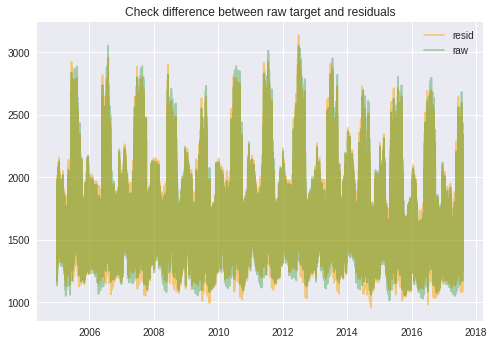

In [ ]:
plt.plot(df_train['resid'], alpha=0.5, label='resid', color='orange')
plt.plot(df_train['DUQ_MW'], alpha=0.3, label='raw', color='green')
plt.legend();
plt.title("Check difference between raw target and residuals");

Resample again

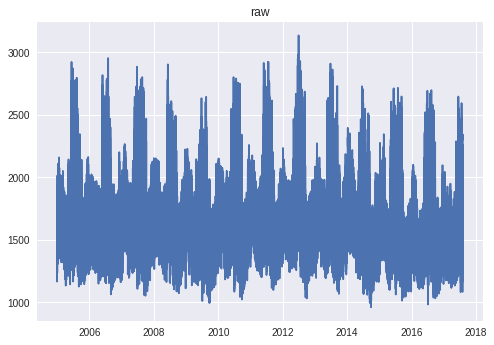

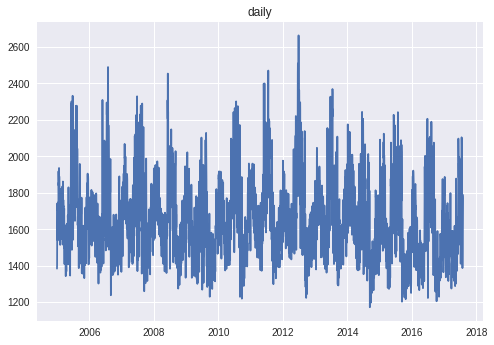

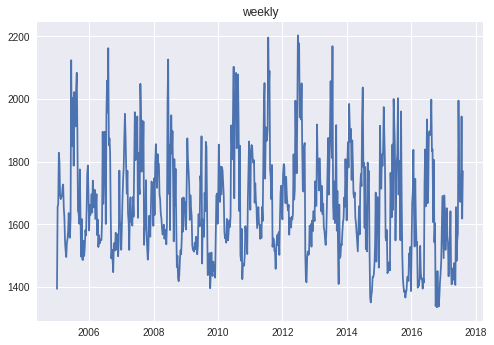

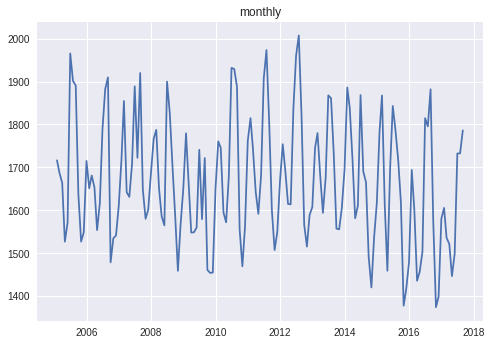

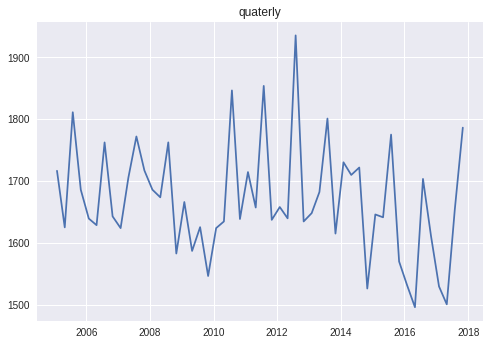

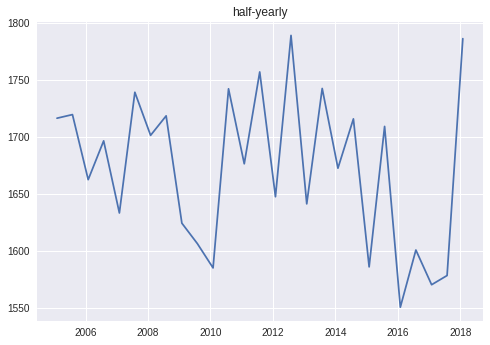

In [ ]:
resid_resampled = resample_resid(df_train['resid'])

### 2.3.3 Monthly resampled data

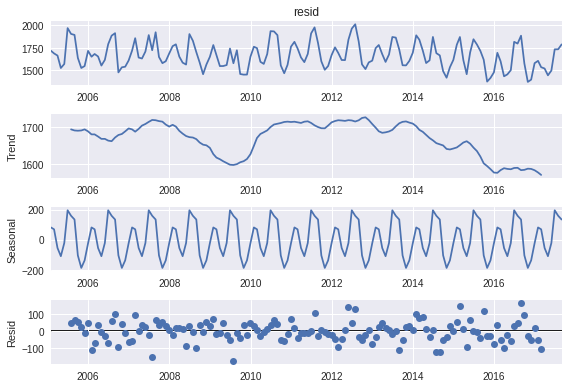

In [ ]:
result = seasonal_decompose(resid_resampled['monthly'], model='additive')
result.plot();

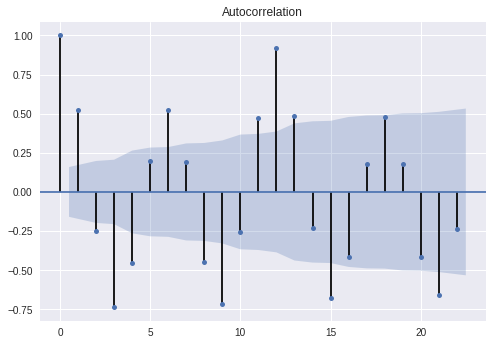

In [ ]:
df_seasonality = result.seasonal.to_frame()
plot_acf(df_seasonality);

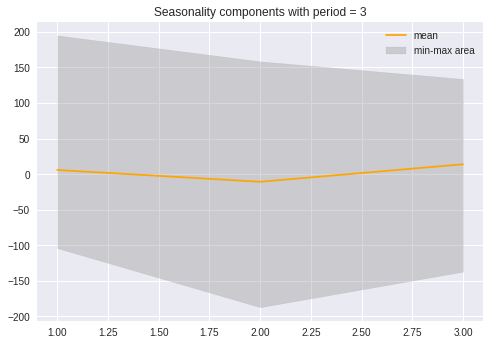

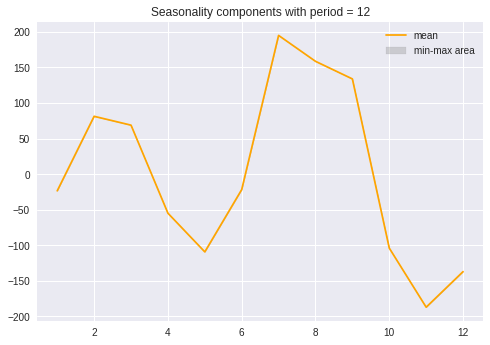

In [ ]:
plot_seasonalty(df_seasonality, [3, 12]);

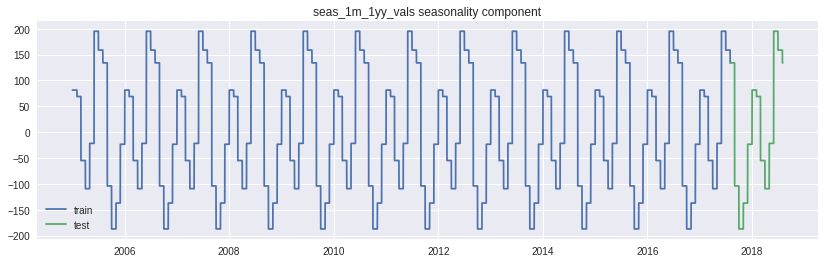

In [ ]:
col_seas = 'seas_1m_1yy'
col_seas_vals = f"{col_seas}_vals"

df_train, df_test = add_seasonal_comp(df_train, df_seasonality, col_seas, get_season_1yy_month, 'resid', df_test)
plot_seasonal_component(df_train, df_test, col_seas_vals)

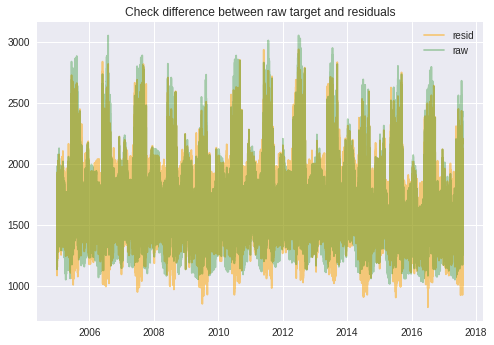

In [ ]:
plt.plot(df_train['resid'], alpha=0.5, label='resid', color='orange')
plt.plot(df_train['DUQ_MW'], alpha=0.3, label='raw', color='green')
plt.legend();
plt.title("Check difference between raw target and residuals");

Resample again

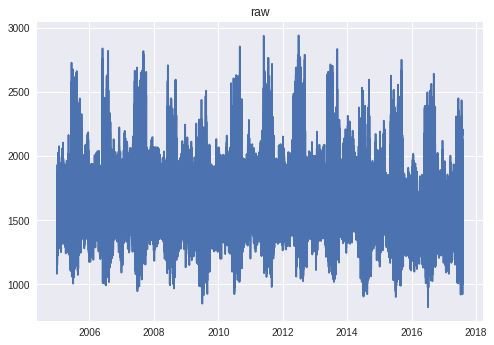

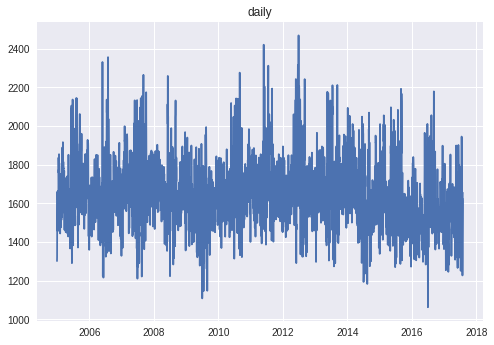

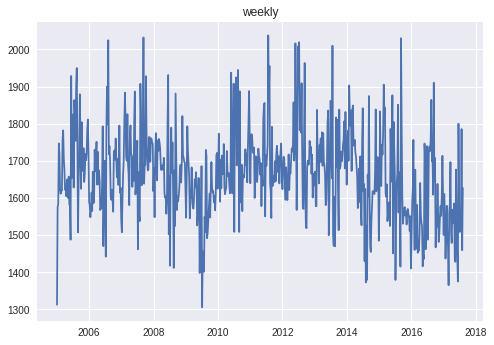

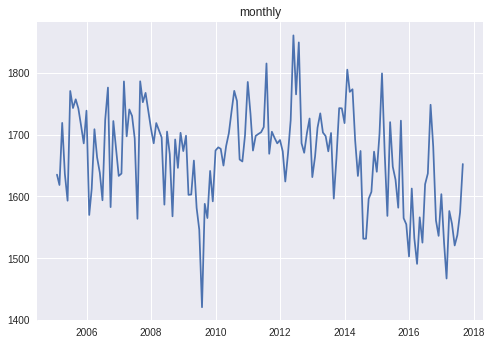

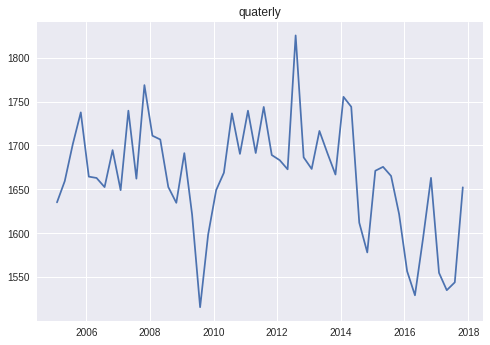

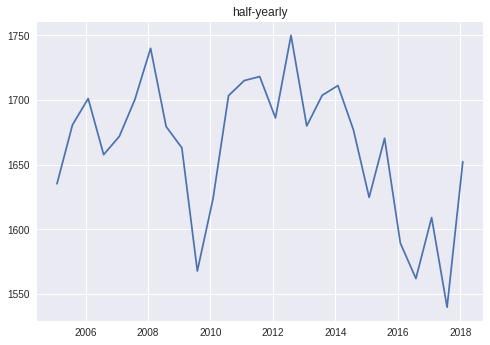

In [ ]:
resid_resampled = resample_resid(df_train['resid'])

### 2.3.4 Weekly resampled data

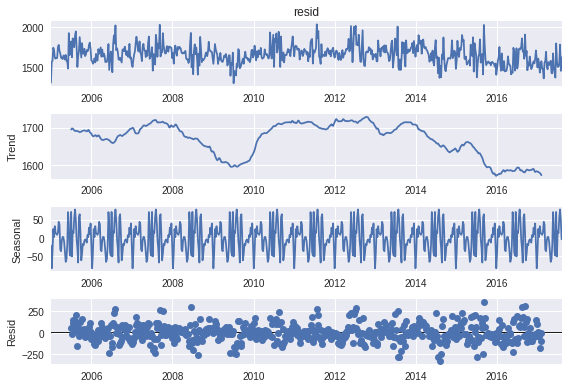

In [ ]:
result = seasonal_decompose(resid_resampled['weekly'], model='additive')
result.plot();

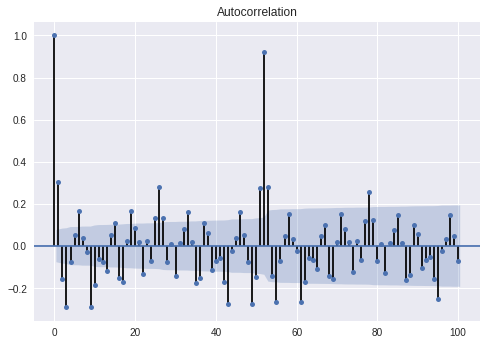

In [ ]:
df_seasonality = result.seasonal.to_frame()
plot_acf(df_seasonality, lags=100);

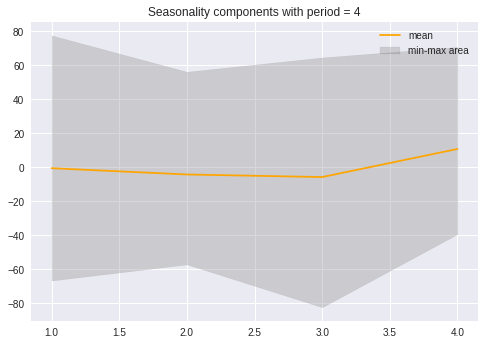

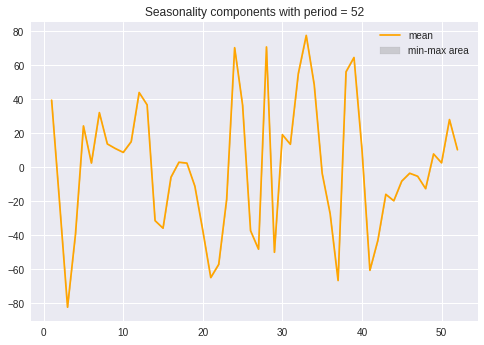

In [ ]:
plot_seasonalty(df_seasonality, [4, 52]);

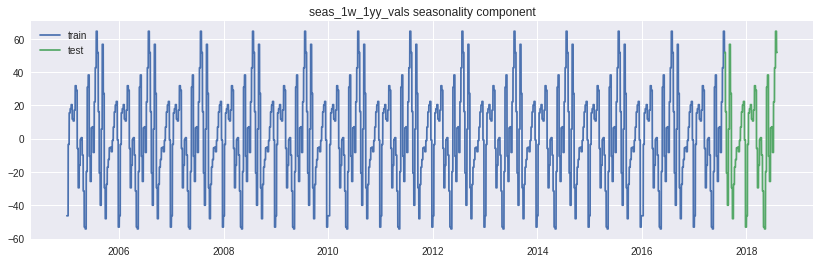

In [ ]:
col_seas = 'seas_1w_1yy'
col_seas_vals = f"{col_seas}_vals"

df_train, df_test = add_seasonal_comp(df_train,df_seasonality, col_seas, get_season_1yy_week, 'resid', df_test)
plot_seasonal_component(df_train, df_test, col_seas_vals)

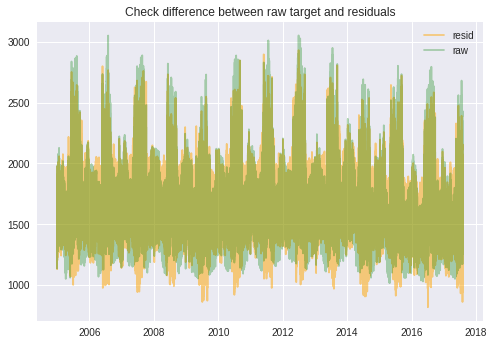

In [ ]:
plt.plot(df_train['resid'], alpha=0.5, label='resid', color='orange')
plt.plot(df_train['DUQ_MW'], alpha=0.3, label='raw', color='green')
plt.legend();
plt.title("Check difference between raw target and residuals");

Resample again

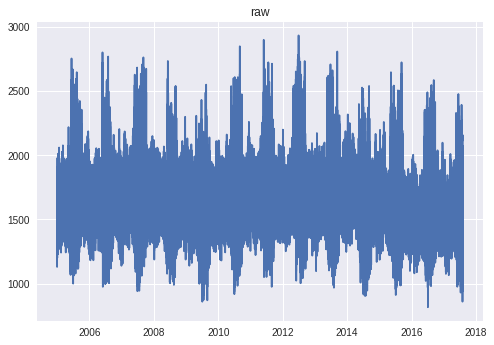

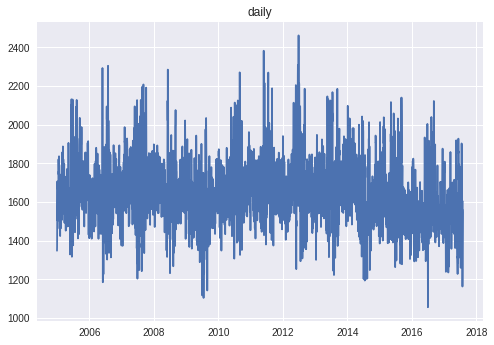

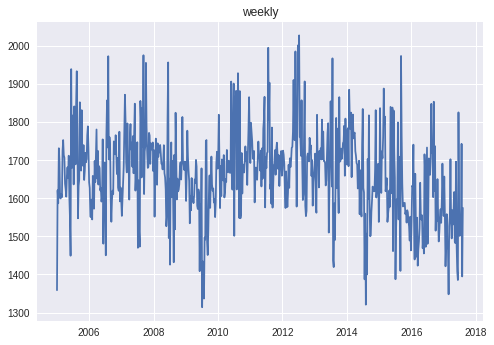

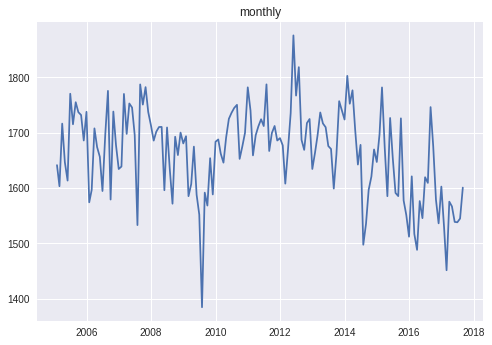

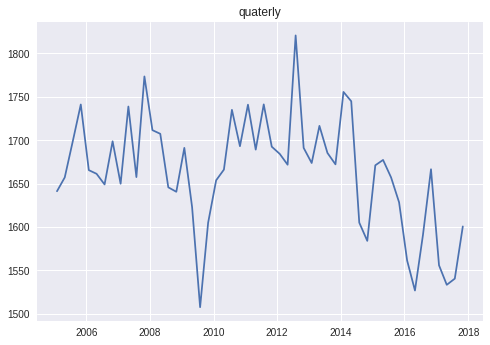

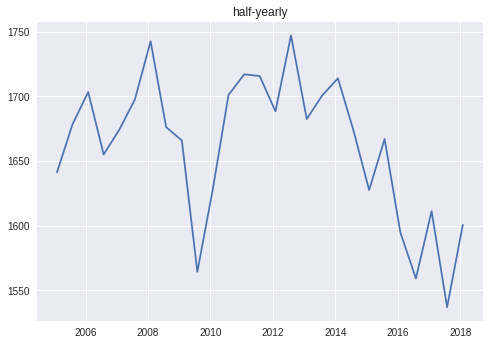

In [ ]:
resid_resampled = resample_resid(df_train['resid'])

### 2.3.5 Seasonalities of daily data for last year

Let's use only last year data to catch more frequent seasonalities

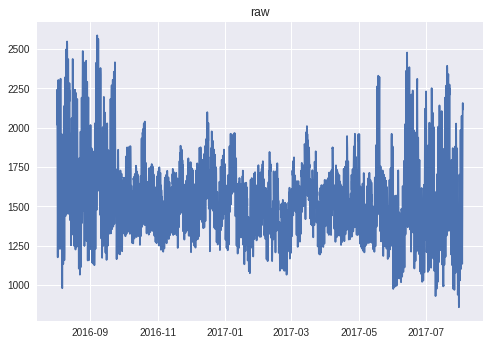

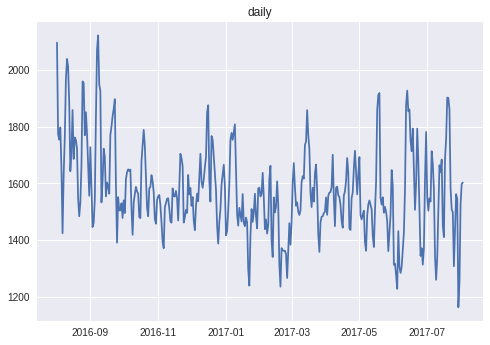

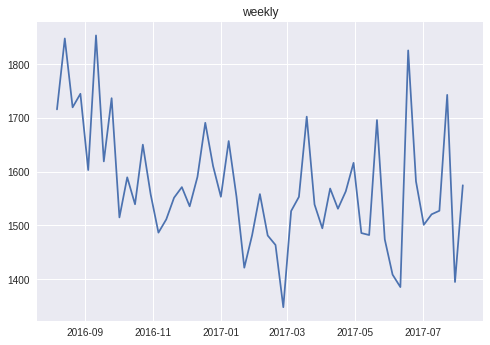

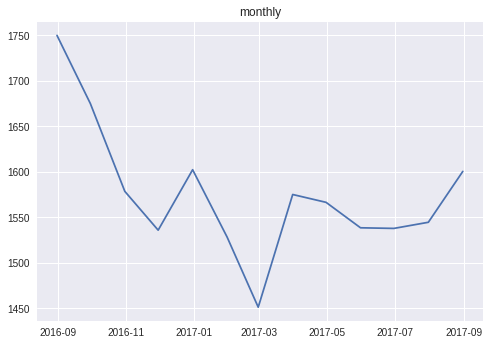

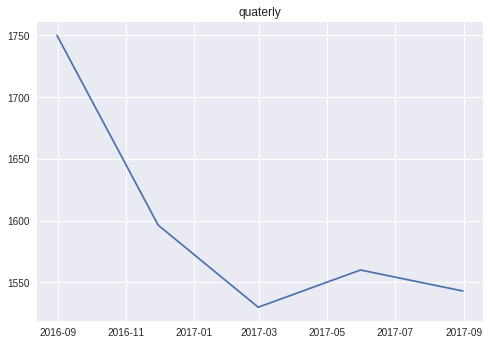

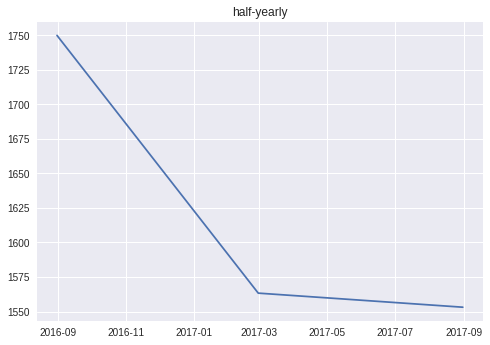

In [ ]:
date_start = df_train.index.max() - pd.Timedelta('1y')
mask_one_year = df_train.index > date_start
resid_resampled = resample_resid(df_train.loc[mask_one_year, 'resid'])

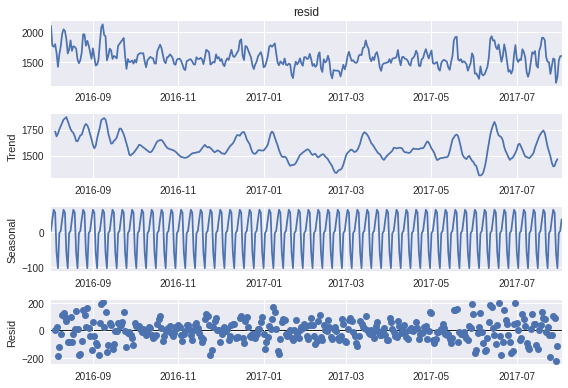

In [ ]:
result = seasonal_decompose(resid_resampled['daily'], model='additive')
result.plot();

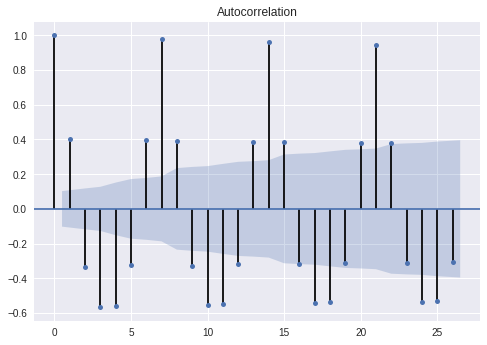

In [ ]:
df_seasonality = result.seasonal.to_frame()
plot_acf(df_seasonality);

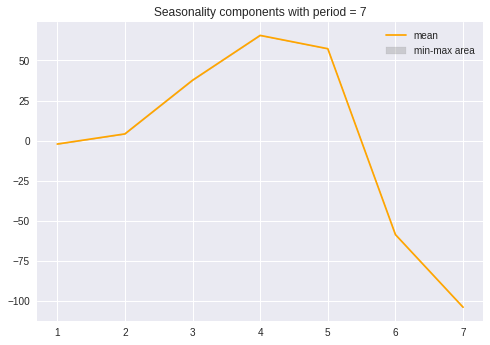

In [ ]:
plot_seasonalty(df_seasonality, [7]);

In [ ]:
col_seas = 'seas_1d_1w'
col_seas_vals = f"{col_seas}_vals"

df_train, df_test = add_seasonal_comp(df_train, df_seasonality, col_seas, get_season_1d_week, 'resid', df_test)

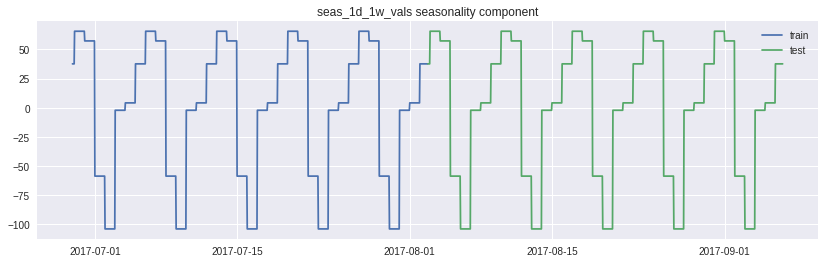

In [ ]:
plot_seasonal_component(df_train, df_test, col_seas_vals, timedelta=pd.Timedelta('5w'))

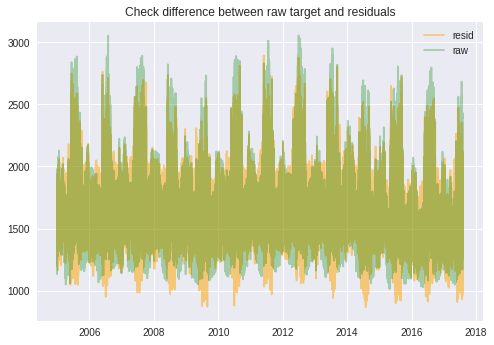

In [ ]:
plt.plot(df_train['resid'], alpha=0.5, label='resid', color='orange')
plt.plot(df_train['DUQ_MW'], alpha=0.3, label='raw', color='green')
plt.legend();
plt.title("Check difference between raw target and residuals");

### 2.3.6 Seasonalities of hourly data for last 1 month

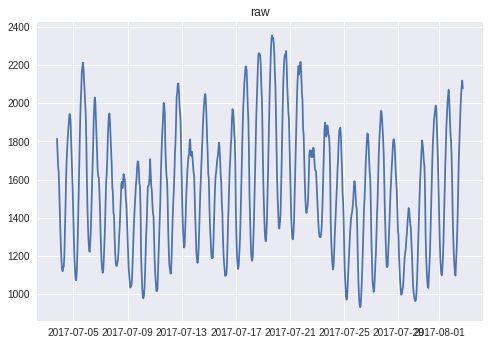

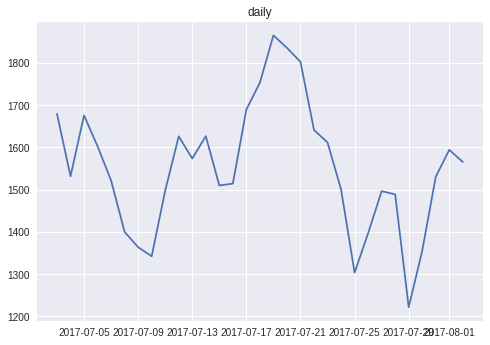

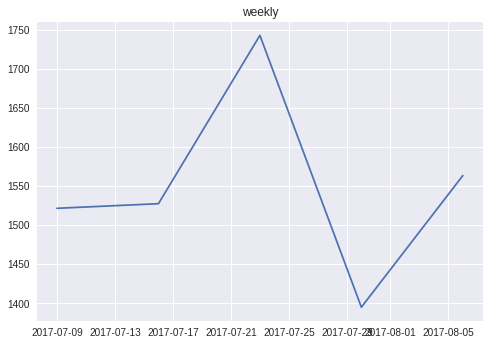

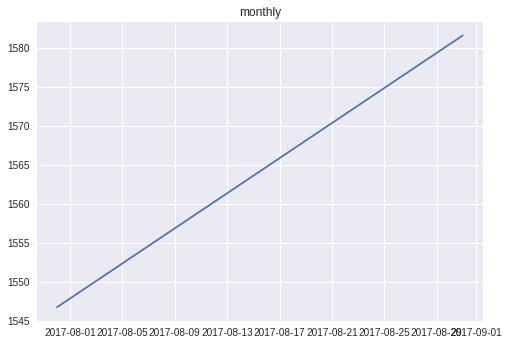

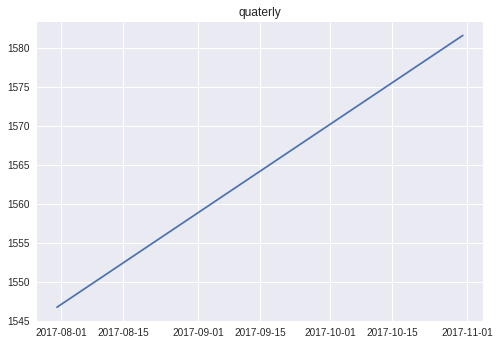

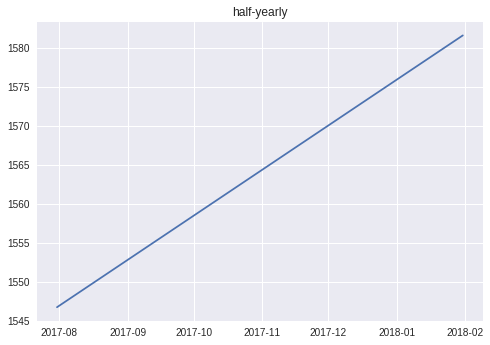

In [ ]:
date_start = df_train.index.max() - pd.Timedelta('30d')
mask_one_month = df_train.index > date_start
resid_resampled = resample_resid(df_train.loc[mask_one_month, 'resid'])

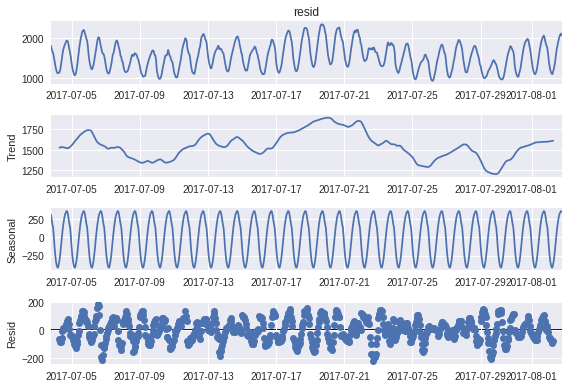

In [ ]:
result = seasonal_decompose(resid_resampled['raw'], model='additive')
result.plot();

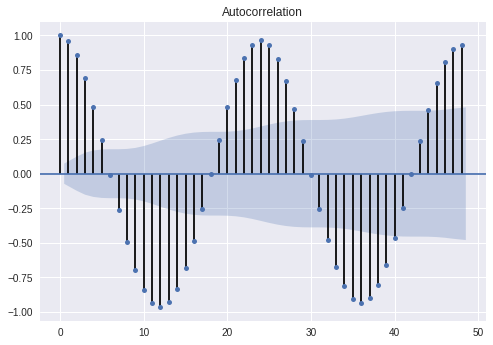

In [ ]:
df_seasonality = result.seasonal.to_frame()
plot_acf(df_seasonality, lags=48);

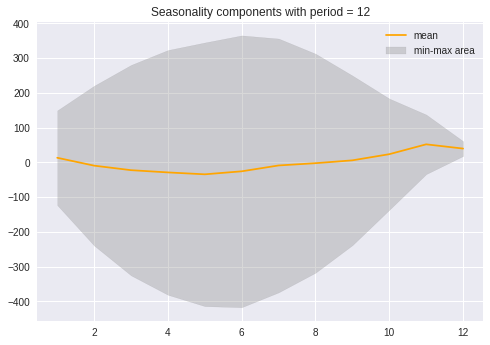

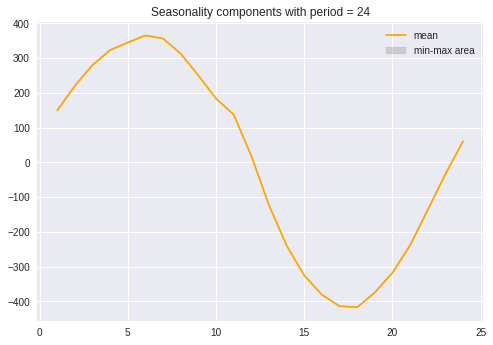

In [ ]:
plot_seasonalty(df_seasonality, [12, 24]);

In [ ]:
col_seas = 'seas_1h_1d'
col_seas_vals = f"{col_seas}_vals"

df_train, df_test = add_seasonal_comp(df_train, df_seasonality, col_seas, get_season_1h_day, 'resid', df_test)

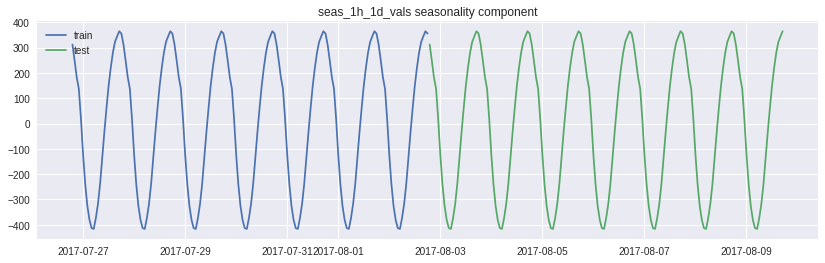

In [ ]:
plot_seasonal_component(df_train, df_test, col_seas_vals, timedelta=pd.Timedelta('1w'))

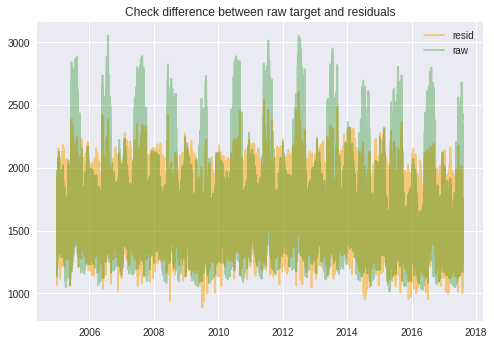

In [ ]:
plt.plot(df_train['resid'], alpha=0.5, label='resid', color='orange')
plt.plot(df_train['DUQ_MW'], alpha=0.3, label='raw', color='green')
plt.legend();
plt.title("Check difference between raw target and residuals");

Looks more like white noise, but still have autocorrelation

In [ ]:
resid_resampled.keys()

dict_keys(['raw', 'daily', 'weekly', 'monthly', 'quaterly', 'half-yearly'])

In [ ]:
resid_resampled = resample_resid(df_train['resid'], make_plot=False)

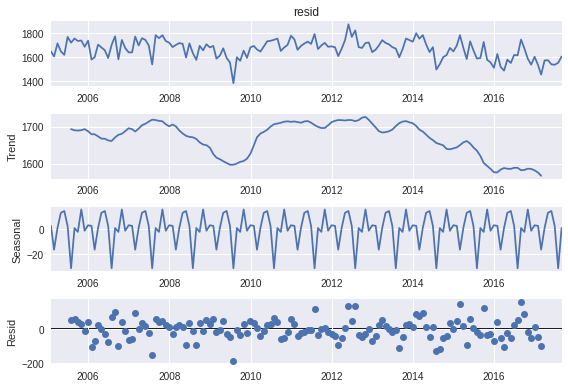

In [ ]:
agg_name = 'monthly'    
resid_resampled_vals = resid_resampled[agg_name]
result = seasonal_decompose(resid_resampled_vals, model='additive')
fig = result.plot();

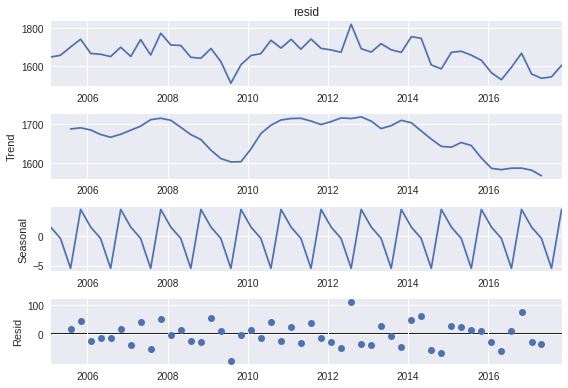

In [ ]:
agg_name = 'quaterly'    
resid_resampled_vals = resid_resampled[agg_name]
result = seasonal_decompose(resid_resampled_vals, model='additive')
fig = result.plot();

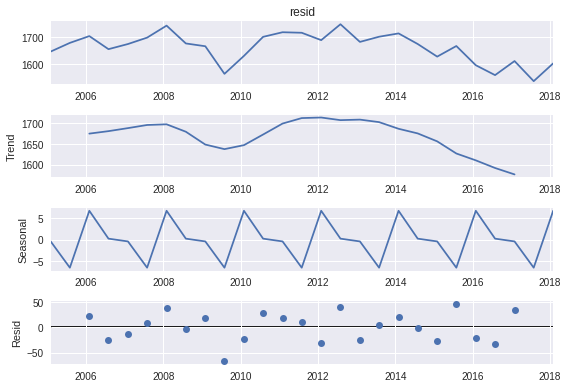

In [ ]:
agg_name = 'half-yearly'   
resid_resampled_vals = resid_resampled[agg_name]
result = seasonal_decompose(resid_resampled_vals, model='additive')
fig = result.plot();

Ok. Seems that we need to do all the work again =) As still some seasonality is not captured

### 2.3.7 Half-yearly seasonality (component 2)

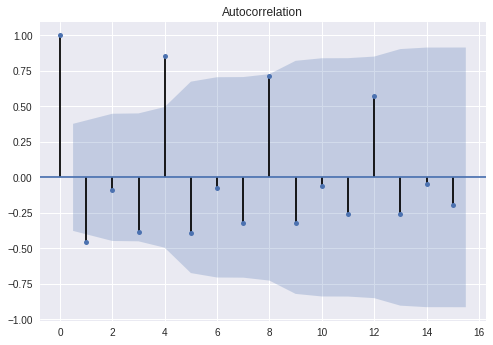

In [ ]:
df_seasonality = result.seasonal.to_frame()
plot_acf(df_seasonality);

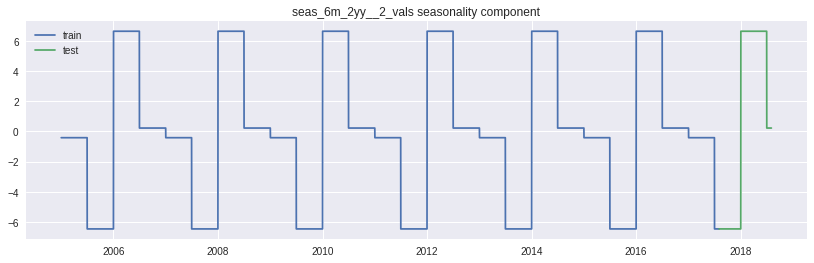

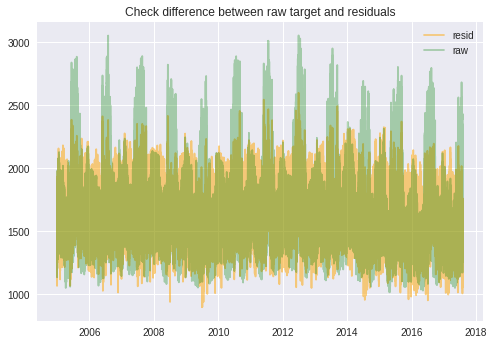

In [ ]:
col_seas = 'seas_6m_2yy__2'
col_seas_vals = f"{col_seas}_vals"

df_train, df_test = add_seasonal_comp(df_train, df_seasonality, col_seas, get_season_2yy, 'resid', df_test)
plot_seasonal_component(df_train, df_test, col_seas_vals)

plt.plot(df_train['resid'], alpha=0.5, label='resid', color='orange')
plt.plot(df_train['DUQ_MW'], alpha=0.3, label='raw', color='green')
plt.legend();
plt.title("Check difference between raw target and residuals");
resid_resampled = resample_resid(df_train['resid'], make_plot=False)


### 2.3.8 Quterly seasonality (component 2)

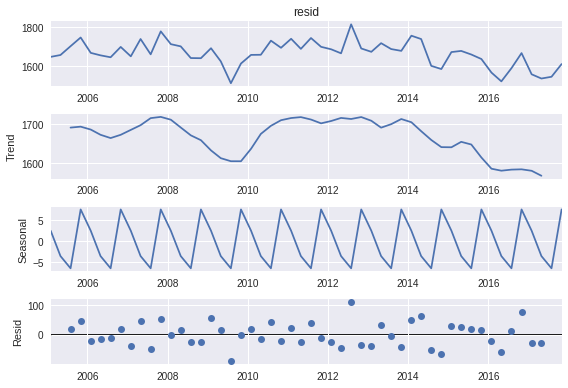

In [ ]:
agg_name = 'quaterly'    
resid_resampled_vals = resid_resampled[agg_name]
result = seasonal_decompose(resid_resampled_vals, model='additive')
fig = result.plot();

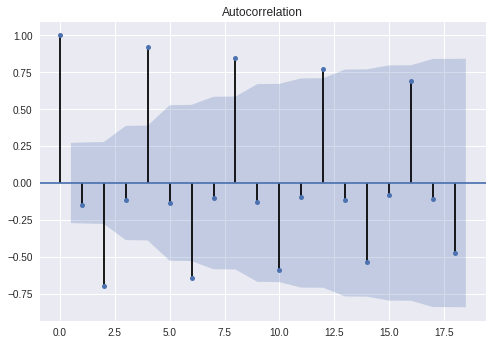

In [ ]:
df_seasonality = result.seasonal.to_frame()
plot_acf(df_seasonality);

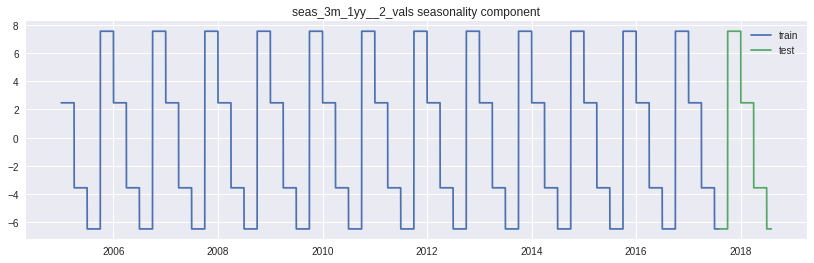

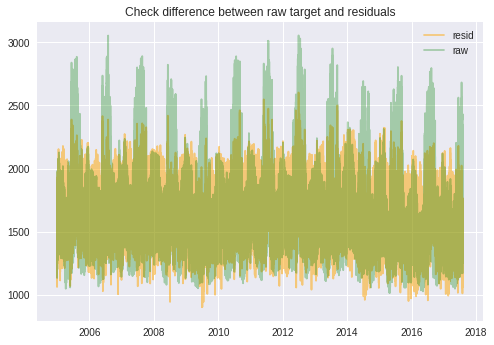

In [ ]:
col_seas = 'seas_3m_1yy__2'
col_seas_vals = f"{col_seas}_vals"

df_train, df_test = add_seasonal_comp(df_train, df_seasonality, col_seas, get_season_1yy_quater, 'resid', df_test)
plot_seasonal_component(df_train, df_test, col_seas_vals)
plt.plot(df_train['resid'], alpha=0.5, label='resid', color='orange')
plt.plot(df_train['DUQ_MW'], alpha=0.3, label='raw', color='green')
plt.legend();
plt.title("Check difference between raw target and residuals");

resid_resampled = resample_resid(df_train['resid'], make_plot=False)

### 2.3.9 Monthly seasonality (component 2)

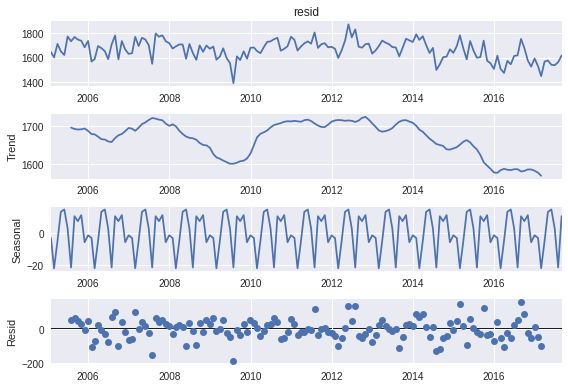

In [ ]:
agg_name = 'monthly'    
resid_resampled_vals = resid_resampled[agg_name]
result = seasonal_decompose(resid_resampled_vals, model='additive')
fig = result.plot();

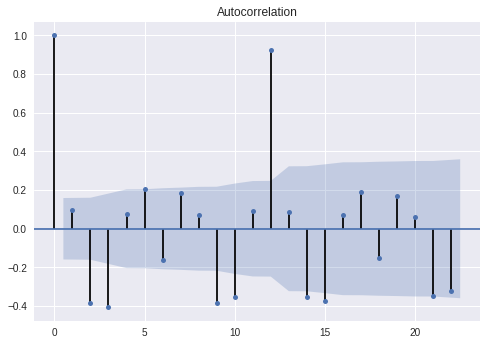

In [ ]:
df_seasonality = result.seasonal.to_frame()
plot_acf(df_seasonality);

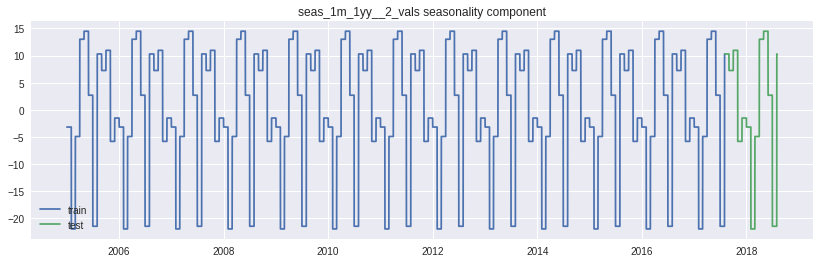

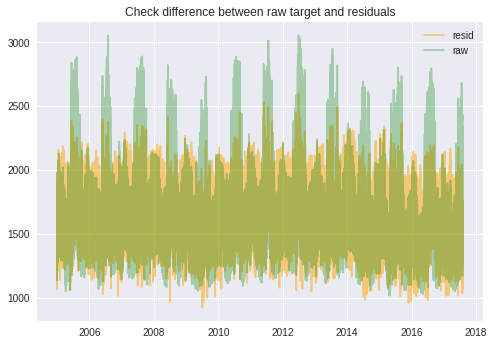

In [ ]:
col_seas = 'seas_1m_1yy__2'
col_seas_vals = f"{col_seas}_vals"

df_train, df_test = add_seasonal_comp(df_train, df_seasonality, col_seas, get_season_1yy_month, 'resid', df_test)
plot_seasonal_component(df_train, df_test, col_seas_vals)
plt.plot(df_train['resid'], alpha=0.5, label='resid', color='orange')
plt.plot(df_train['DUQ_MW'], alpha=0.3, label='raw', color='green')
plt.legend();
plt.title("Check difference between raw target and residuals");

resid_resampled = resample_resid(df_train['resid'], make_plot=False)

### 2.3.10 Weekly seasonality (component 2)

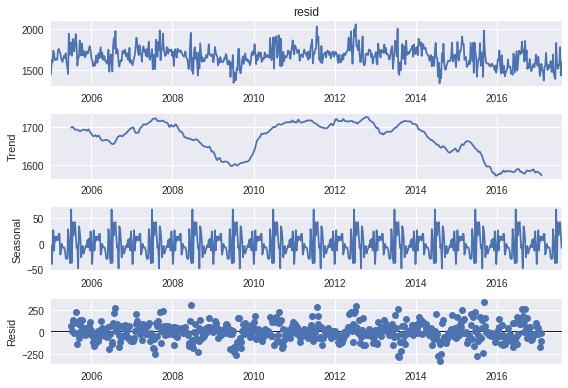

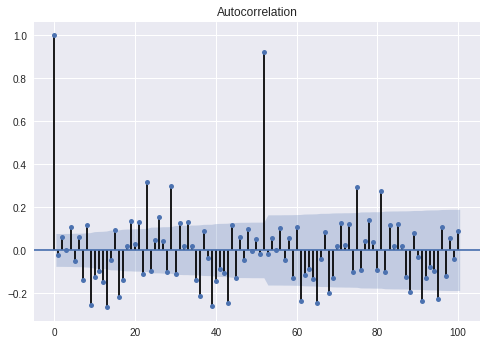

In [ ]:
result = seasonal_decompose(resid_resampled['weekly'], model='additive')
result.plot();
df_seasonality = result.seasonal.to_frame()
plot_acf(df_seasonality, lags=100);

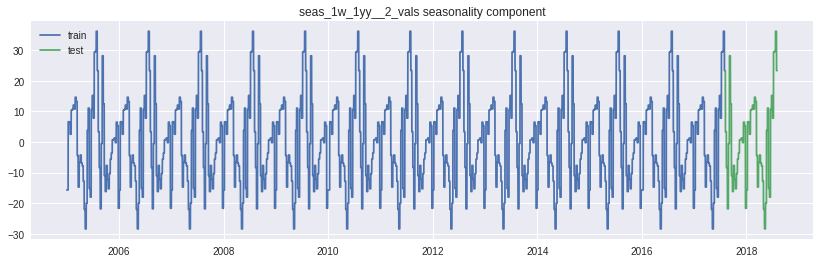

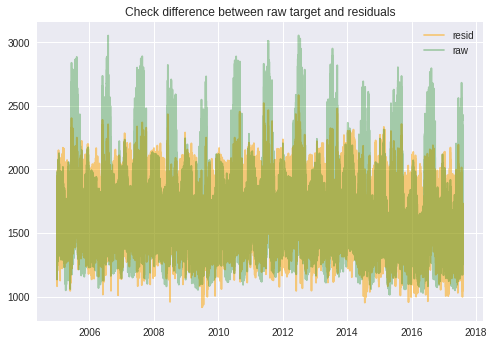

In [ ]:
col_seas = 'seas_1w_1yy__2'
col_seas_vals = f"{col_seas}_vals"

df_train, df_test = add_seasonal_comp(df_train,df_seasonality, col_seas, get_season_1yy_week, 'resid', df_test)
plot_seasonal_component(df_train, df_test, col_seas_vals)

plt.plot(df_train['resid'], alpha=0.5, label='resid', color='orange')
plt.plot(df_train['DUQ_MW'], alpha=0.3, label='raw', color='green')
plt.legend();
plt.title("Check difference between raw target and residuals");

resid_resampled = resample_resid(df_train['resid'], make_plot=False)

### 2.3.11 Seasonalities of daily data for last year (component 2)

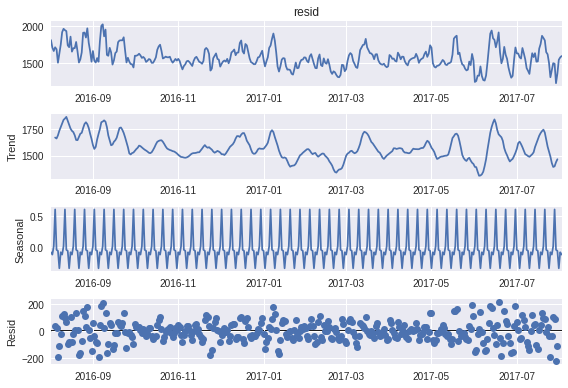

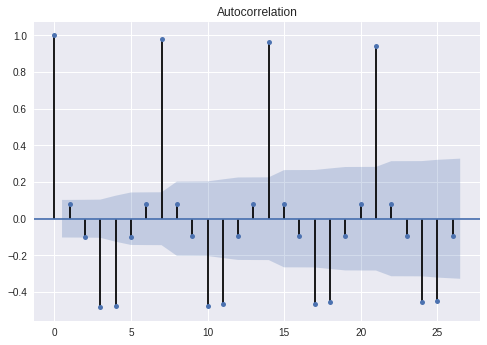

In [ ]:
date_start = df_train.index.max() - pd.Timedelta('1y')
mask_one_year = df_train.index > date_start
resid_resampled = resample_resid(df_train.loc[mask_one_year, 'resid'], make_plot=False)
result = seasonal_decompose(resid_resampled['daily'], model='additive')
result.plot();
df_seasonality = result.seasonal.to_frame()
plot_acf(df_seasonality);

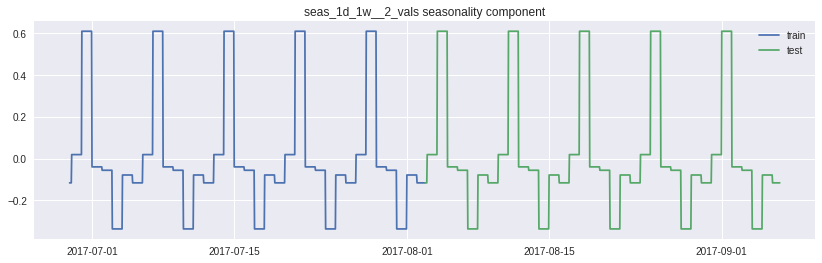

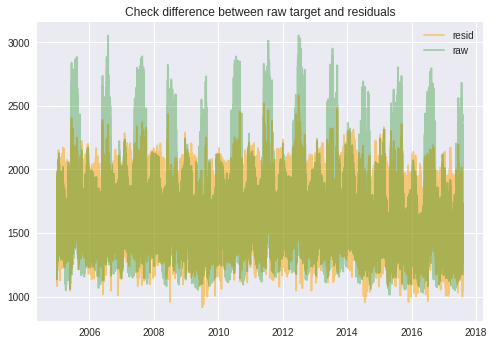

In [ ]:
col_seas = 'seas_1d_1w__2'
col_seas_vals = f"{col_seas}_vals"
df_train, df_test = add_seasonal_comp(df_train, df_seasonality, col_seas, get_season_1d_week, 'resid', df_test)
plot_seasonal_component(df_train, df_test, col_seas_vals, timedelta=pd.Timedelta('5w'))
plt.plot(df_train['resid'], alpha=0.5, label='resid', color='orange')
plt.plot(df_train['DUQ_MW'], alpha=0.3, label='raw', color='green')
plt.legend();
plt.title("Check difference between raw target and residuals");

### 2.3.12 Seasonalities of hourly data for last 1 month

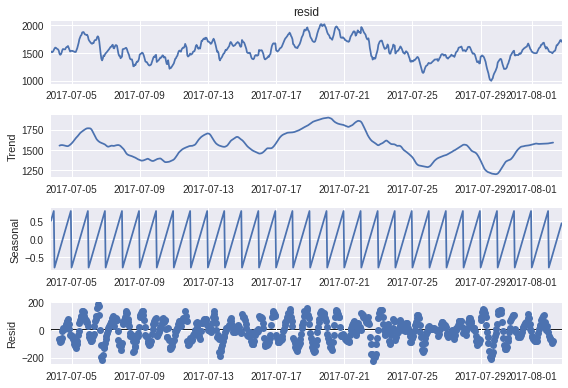

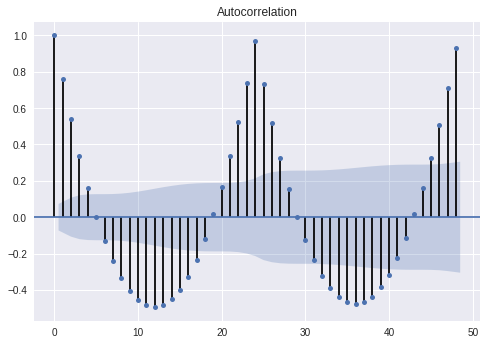

In [ ]:
date_start = df_train.index.max() - pd.Timedelta('30d')
mask_one_month = df_train.index > date_start
resid_resampled = resample_resid(df_train.loc[mask_one_month, 'resid'], make_plot=False)

result = seasonal_decompose(resid_resampled['raw'], model='additive')
result.plot();

df_seasonality = result.seasonal.to_frame()
plot_acf(df_seasonality, lags=48);


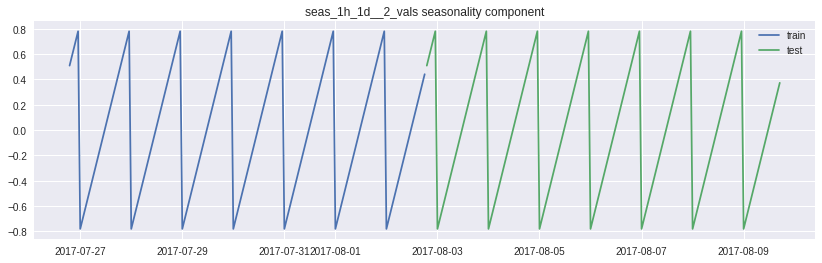

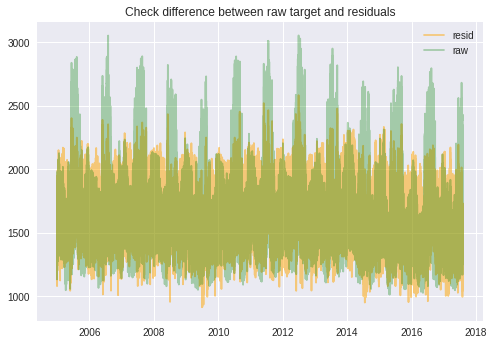

In [ ]:
col_seas = 'seas_1h_1d__2'
col_seas_vals = f"{col_seas}_vals"

df_train, df_test = add_seasonal_comp(df_train, df_seasonality, col_seas, get_season_1h_day, 'resid', df_test)
plot_seasonal_component(df_train, df_test, col_seas_vals, timedelta=pd.Timedelta('1w'))
plt.plot(df_train['resid'], alpha=0.5, label='resid', color='orange')
plt.plot(df_train['DUQ_MW'], alpha=0.3, label='raw', color='green')
plt.legend();
plt.title("Check difference between raw target and residuals");

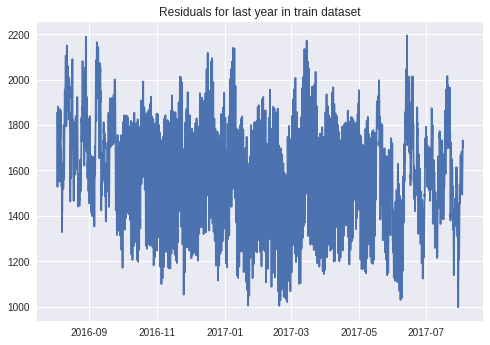

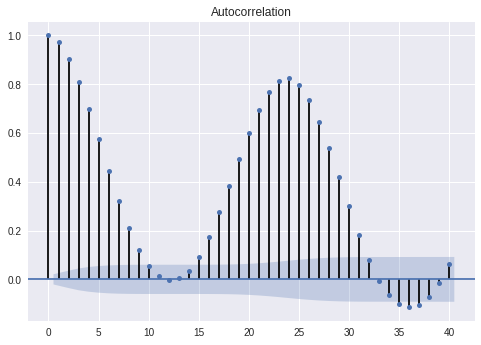

In [ ]:
plt.plot(df_train['resid'].iloc[-365*24:])
plt.title("Residuals for last year in train dataset");
plot_acf(df_train['resid'].iloc[-365*24:]);

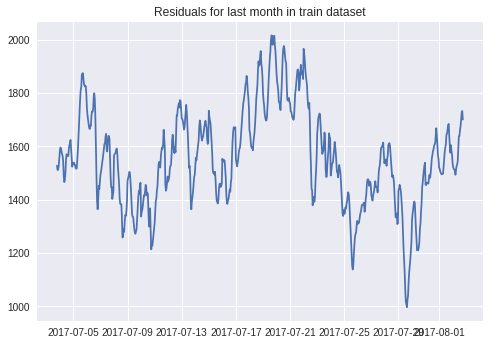

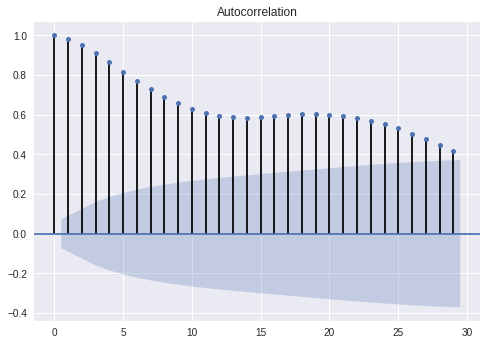

In [ ]:
plt.plot(df_train['resid'].iloc[-30*24:])
plt.title("Residuals for last month in train dataset");
plot_acf(df_train['resid'].iloc[-30*24:]);

Inspite we still see some seasonality pattern (accoring to ACF), we see that components added in the second run are already really tiny (in absolute values), so we won't add seasonality components anymore. 

**Good news:** things above could be automated, you can use ACF values to define the seasonality frequency.

Let's now find a trend.

## 2.4 Add trend feature


### 2.4.1 First glance ar smoothing Holt

In [ ]:
resid_vals = df_train['resid'].resample('1h').mean()
fill_nan_ma = resid_vals.rolling(window=3, center=True, min_periods=1).mean()
indx_na = resid_vals.isna()
resid_vals.loc[indx_na] = fill_nan_ma.loc[indx_na]

In [ ]:
model = Holt(resid_vals)
model_fit = model.fit()
trend_train = model_fit.fittedvalues
trend_test  = model_fit.forecast(24*365)

In [ ]:
trend_train = trend_train.to_frame()
trend_test = trend_test.to_frame()

trend_train.columns = ['trend']
trend_test.columns = ['trend']

In [ ]:
df_train.shape

(110302, 42)

In [ ]:
df_train = df_train.join(trend_train, how='left')
df_test = df_test.join(trend_test, how='left')

Holt model without parameters tuning gives unexpected results

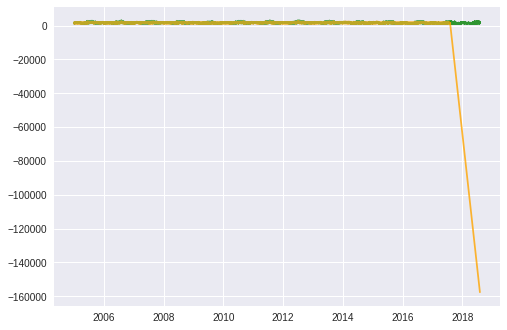

In [ ]:
plt.plot(df_train['DUQ_MW'], label='target train', color='green', alpha=0.6)
plt.plot(df_test['DUQ_MW'], label='target test', color='green', alpha=0.8)

plt.plot(df_train['trend'], label='trend train', color='orange', alpha=0.6)
plt.plot(df_test['trend'], label='trend test', color='orange', alpha=0.8)

### 2.4.2 First glance ar smoothing Exponential Smoothing

In [ ]:
model = SimpleExpSmoothing(resid_vals)
model_fit = model.fit()
trend_train = model_fit.fittedvalues
trend_test  = model_fit.forecast(24*365)

In [ ]:
trend_train = trend_train.to_frame()
trend_test = trend_test.to_frame()

trend_train.columns = ['trend']
trend_test.columns = ['trend']

In [ ]:
df_train.drop(columns=['trend'], inplace=True)
df_test.drop(columns=['trend'], inplace=True)

In [ ]:
df_train = df_train.join(trend_train, how='left')
df_test = df_test.join(trend_test, how='left')

Simple exponential smoothing is better without parameter tuning as it simply converges to mean

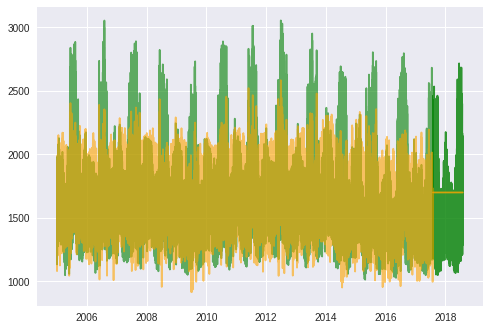

In [ ]:
plt.plot(df_train['DUQ_MW'], label='target train', color='green', alpha=0.6)
plt.plot(df_test['DUQ_MW'], label='target test', color='green', alpha=0.8)

plt.plot(df_train['trend'], label='trend train', color='orange', alpha=0.6)
plt.plot(df_test['trend'], label='trend test', color='orange', alpha=0.8)

In [ ]:
df_train.drop(columns=['trend'], inplace=True)
df_test.drop(columns=['trend'], inplace=True)

### 2.4.3 Try trend on resampled data

Probably noise of high-frequency data deteriorate the quality, let's find trend component on resampled data

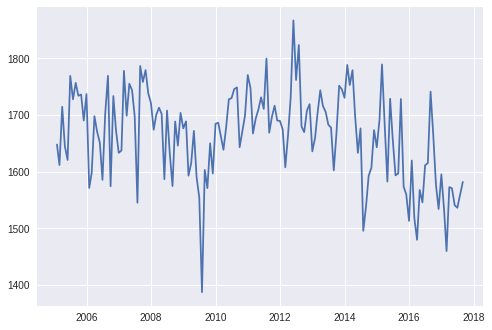

In [ ]:
resid_vals = resid_vals.resample('1m').mean()
plt.plot(resid_vals);

In [ ]:
mask_train = resid_vals.index < resid_vals.index[-12]
resid_vals_train = resid_vals.loc[mask_train]
resid_vals_val = resid_vals.loc[~mask_train]

In [ ]:
holt_params ={
    'smoothing_level': np.power(1.1, np.linspace(-50, -1, 20)),
    'smoothing_slope': np.power(1.1, np.linspace(-50, -1, 20)),
}

In [ ]:
result_df = pd.DataFrame(index=range(400), columns=list(holt_params.keys()) + ['mae_train', 'mae_val'])

In [ ]:
holt_paams_all = (itertools.product(
    holt_params['smoothing_level'],
    holt_params['smoothing_slope'],
))

In [ ]:
for i, (sl, ss) in enumerate(holt_paams_all):
    model = Holt(resid_vals_train)
    model_fit = model.fit(smoothing_level=sl, smoothing_slope=ss)
    trend_train = model_fit.fittedvalues
    trend_val  = model_fit.forecast(12)
    mae_train = mean_absolute_error(trend_train, resid_vals_train)
    mae_val = mean_absolute_error(trend_val, resid_vals_val)
    
    result_df.loc[i] = [sl, ss, mae_train, mae_val]

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [ ]:
result_df.sort_values(by='mae_val', inplace=True)
result_df.head(10)

smoothing_level smoothing_slope mae_train  mae_val
250         0.16269       0.0995088    58.353  32.0624
249         0.16269       0.0778237   57.5222  32.0734
227        0.127236       0.0476006   56.2728  32.2759
251         0.16269        0.127236   59.3643   32.376
207       0.0995088       0.0476006   56.9562  32.4202
248         0.16269       0.0608642   56.8122  32.4612
228        0.127236       0.0608642   56.8219  32.4659
135       0.0372274        0.340102   68.1511  32.4885
208       0.0995088       0.0608642   57.4145  32.7214
188       0.0778237       0.0608642   57.9608   32.874

In [ ]:
model = Holt(resid_vals)
model_fit = model.fit(
    smoothing_level=result_df.smoothing_level.iloc[0], 
    smoothing_slope=result_df.smoothing_slope.iloc[0]
)
trend_train = model_fit.fittedvalues
trend_test  = model_fit.forecast(12)

In [ ]:
trend_train = trend_train.to_frame()
trend_test = trend_test.to_frame()

trend_train.columns = ['trend']
trend_test.columns = ['trend']

In [ ]:
trend_train['year'] = trend_train.index.year
trend_train['month'] = trend_train.index.month

trend_test['year'] = trend_test.index.year
trend_test['month'] = trend_test.index.month

In [ ]:
if 'trend' in df_train.columns:
    df_train.drop(columns=['trend'], inplace=True)
if 'trend' in df_test.columns:
    df_test.drop(columns=['trend'], inplace=True)

In [ ]:
trend_all = pd.concat([trend_train, trend_test])

In [ ]:
df_train['trend'] = df_train.merge(trend_all, on=['year', 'month'], how='left')['trend'].values
df_test['trend'] = df_test.merge(trend_all, on=['year', 'month'], how='left')['trend'].values

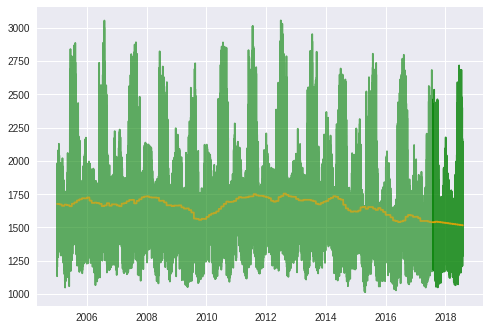

In [ ]:
plt.plot(df_train['DUQ_MW'], label='target train', color='green', alpha=0.6)
plt.plot(df_test['DUQ_MW'], label='target test', color='green', alpha=0.8)

plt.plot(df_train['trend'], label='trend train', color='orange', alpha=0.6)
plt.plot(df_test['trend'], label='trend test', color='orange', alpha=0.8)

## 2.5 Train model with seasonal features

In [ ]:
seas_cols = [x for x in df_train.columns if re.search(r"seas\_.*\_vals", x)]
seas_cols

['seas_6m_2yy_vals',
 'seas_3m_1yy_vals',
 'seas_1m_1yy_vals',
 'seas_1w_1yy_vals',
 'seas_1d_1w_vals',
 'seas_1h_1d_vals',
 'seas_6m_2yy__2_vals',
 'seas_3m_1yy__2_vals',
 'seas_1m_1yy__2_vals',
 'seas_1w_1yy__2_vals',
 'seas_1d_1w__2_vals',
 'seas_1h_1d__2_vals']

In [ ]:
features = ['year', 'month', 'day', 'hour'] + seas_cols + ["trend"]
target = ['DUQ_MW']

In [ ]:
X_train = df_train[features]
y_train = df_train[target]

X_test = df_test[features]
y_test = df_test[target]

In [ ]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('lm', LinearRegression())])
cv_ts = TimeSeriesSplit(n_splits=7)
cross_val_score(pipe, X_train, y_train, cv=cv_ts, scoring=mae_score)

array([-158.33712926, -200.64475562, -138.93948803, -143.17941558,
       -134.03028819, -161.26088361, -150.49081525])

In [ ]:
pipe.fit(X_train, y_train);
model = pipe.named_steps['lm']
pd.DataFrame(model.coef_, columns=X_train.columns)

year     month       day           hour  seas_6m_2yy_vals  \
0 -32.22217  5.413436 -1.365755  102881.638965          6.332406   

   seas_3m_1yy_vals  seas_1m_1yy_vals  seas_1w_1yy_vals  seas_1d_1w_vals  \
0         164.95572        385.706712         38.004805       230.010559   

   seas_1h_1d_vals  seas_6m_2yy__2_vals  seas_3m_1yy__2_vals  \
0       483.230236            16.926399            38.974171   

   seas_1m_1yy__2_vals  seas_1w_1yy__2_vals  seas_1d_1w__2_vals  \
0            96.495279           194.588949          -71.891944   

   seas_1h_1d__2_vals       trend  
0      -102829.930438  131.156109

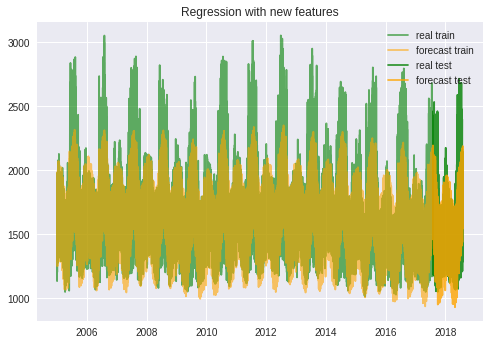

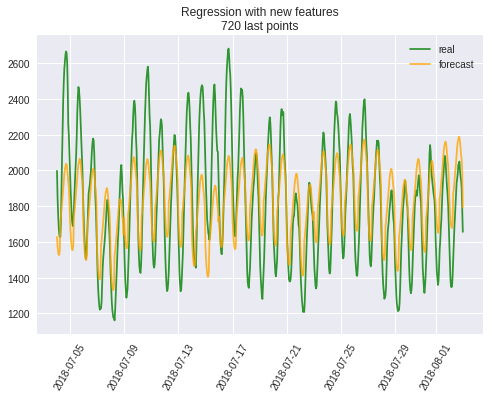

In [ ]:
plt.plot(y_train, label='real train', color='green', alpha=0.6)
plt.plot(y_train.index, pipe.predict(X_train), label='forecast train', color='orange', alpha=0.6)
plt.plot(y_test, label='real test', color='green', alpha=0.8)
plt.plot(y_test.index, pipe.predict(X_test), label='forecast test', color='orange', alpha=0.8)
plt.legend();
plt.title('Regression with new features');
plt.show()

k = 24 * 30 # month
plt.plot(y_test.iloc[-k:], label='real', color='green', alpha=0.8)
plt.plot(y_test.index[-k:], pipe.predict(X_test)[-k:], label='forecast', color='orange', alpha=0.8)
plt.legend();
plt.title('Regression with new features' + f"\n{k} last points");
plt.xticks(rotation=60);
plt.show();

In [ ]:
y_hat_train = pipe.predict(X_train)
y_hat_test = pipe.predict(X_test)
get_metric_report(y_hat_train, y_train, y_hat_test, y_test)

Train error
	MAPE =   0.08
	MSE = 135.91
Test error
	MAPE =   0.10
	MAE = 150.28


### 2.5.1 Regularization

Seems we have problems with multicollinearity :(

In [ ]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('elm', ElasticNet())])
cv_ts = TimeSeriesSplit(n_splits=7)
# cross_val_score(pipe, X_train, y_train, cv=cv_ts)

param_dist = {
          'elm__alpha': np.random.rand(100), 
          'elm__l1_ratio': np.random.rand(100), 
}

search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=50, scoring=mae_score, cv=cv_ts)
search.fit(X_train, y_train);

In [ ]:
search.best_params_

{'elm__l1_ratio': 0.9904678576291152, 'elm__alpha': 0.9738615528530853}

In [ ]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('elm', ElasticNet())])
cv_ts = TimeSeriesSplit(n_splits=7)
# cross_val_score(pipe, X_train, y_train, cv=cv_ts)

var = 0.2
param_dist = {
          'elm__alpha': np.maximum(np.minimum(np.random.rand(100) * var + search.best_params_['elm__alpha'] - var * 0.5, 1), 0), 
          'elm__l1_ratio': np.maximum(np.minimum(np.random.rand(100) * var + search.best_params_['elm__l1_ratio'] - var * 0.5, 1), 0), 
}

search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=50, scoring=mae_score, cv=cv_ts)
search.fit(X_train, y_train);

In [ ]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
40       0.046939      0.019427         0.004595        0.000210   
23       0.041435      0.015719         0.004407        0.000230   
31       0.039068      0.016899         0.004417        0.000609   
49       0.057800      0.024399         0.004984        0.000694   
1        0.050829      0.025542         0.004629        0.000409   

   param_elm__l1_ratio param_elm__alpha  \
40             0.98988                1   
23            0.984296                1   
31            0.981512          0.89024   
49                   1                1   
1                    1                1   

                                               params  split0_test_score  \
40  {'elm__l1_ratio': 0.9898800069449455, 'elm__al...        -139.009919   
23  {'elm__l1_ratio': 0.9842955530239591, 'elm__al...        -139.606644   
31  {'elm__l1_ratio': 0.9815115737193073, 'elm__al...        -139.843390   
49          {'elm__l1_ratio': 1.0, 'elm__alpha': 1.0}        -145.456280   
1           {'elm__l1_ratio': 1.0, 'elm__alpha': 1.0}        -145.456280   

    split1_test_score  split2_test_score  split3_test_score  \
40        -167.234405        -133.415636        -145.763053   
23        -165.988455        -133.619953        -146.672697   
31        -166.999668        -133.856683        -146.719820   
49        -170.134716        -136.248713        -145.031643   
1         -170.134716        -136.248713        -145.031643   

    split4_test_score  split5_test_score  split6_test_score  mean_test_score  \
40        -133.757814        -165.190624        -164.850656      -149.888872   
23        -133.783763        -166.649219        -167.291702      -150.516062   
31        -133.884615        -166.895583        -166.945379      -150.735020   
49        -135.828439        -163.209059        -159.993574      -150.843203   
1         -135.828439        -163.209059        -159.993574      -150.843203   

    std_test_score  rank_test_score  
40       14.271944                1  
23       14.542209                2  
31       14.599619                3  
49       12.592751                4  
1        12.592751                4

In [ ]:
model = search.best_estimator_

In [ ]:
pd.DataFrame([model.named_steps['elm'].coef_], columns=X_train.columns)

year  month  day       hour  seas_6m_2yy_vals  seas_3m_1yy_vals  \
0 -28.812601    0.0 -0.0  59.817517         25.507377        118.395114   

   seas_1m_1yy_vals  seas_1w_1yy_vals  seas_1d_1w_vals  seas_1h_1d_vals  \
0        299.382054         79.180813       194.320888       368.733854   

   seas_6m_2yy__2_vals  seas_3m_1yy__2_vals  seas_1m_1yy__2_vals  \
0                 -0.0           -19.562658                  0.0   

   seas_1w_1yy__2_vals  seas_1d_1w__2_vals  seas_1h_1d__2_vals       trend  
0            84.486403          -39.275652           58.778456  105.303157

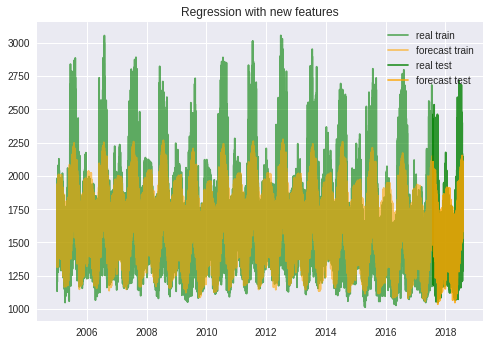

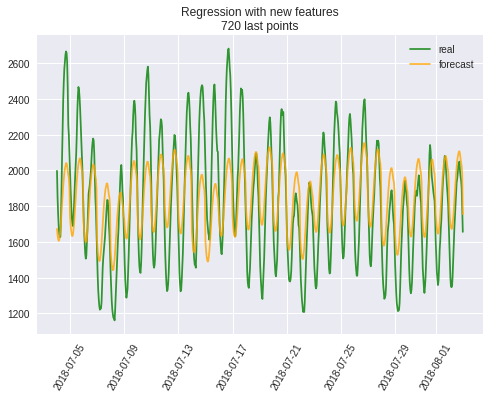

In [ ]:
plt.plot(y_train, label='real train', color='green', alpha=0.6)
plt.plot(y_train.index, model.predict(X_train), label='forecast train', color='orange', alpha=0.6)
plt.plot(y_test, label='real test', color='green', alpha=0.8)
plt.plot(y_test.index, model.predict(X_test), label='forecast test', color='orange', alpha=0.8)
plt.legend();
plt.title('Regression with new features');
plt.show()

k = 24 * 30 # month
plt.plot(y_test.iloc[-k:], label='real', color='green', alpha=0.8)
plt.plot(y_test.index[-k:], model.predict(X_test)[-k:], label='forecast', color='orange', alpha=0.8)
plt.legend();
plt.title('Regression with new features' + f"\n{k} last points");
plt.xticks(rotation=60);
plt.show();

In [ ]:
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)
get_metric_report(y_hat_train, y_train, y_hat_test, y_test)

Train error
	MAPE =   0.08
	MSE = 140.18
Test error
	MAPE =   0.09
	MAE = 149.63


## 2.6 Look into residuals

In [ ]:
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)

resid_train = y_hat_train - y_train.iloc[:, 0]
resid_test = y_hat_test - y_test.iloc[:, 0]

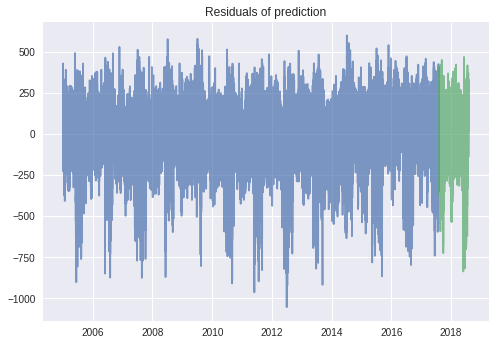

In [ ]:
plt.plot(resid_train, alpha=0.7, label='train')
plt.plot(resid_test, alpha=0.7, label='test')
plt.title('Residuals of prediction');

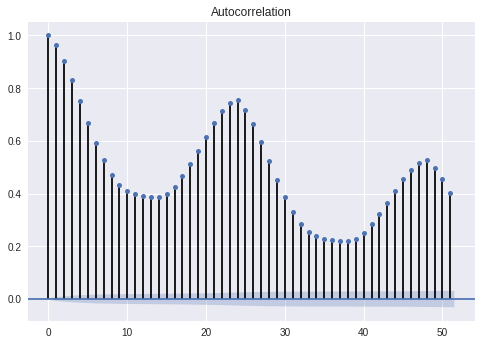

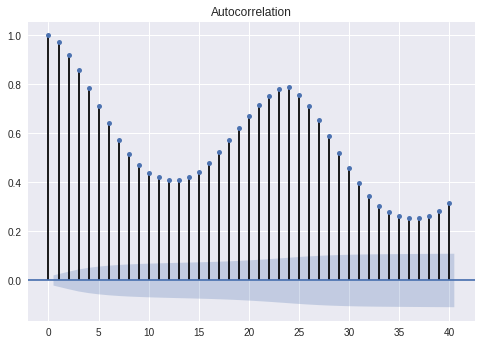

In [ ]:
plot_acf(resid_train);
plot_acf(resid_test);

Errors still have systematic component and moreover, we see underpredict for many periods. 
In ideal world we are supposed to remove all systematic components from residuals.

### 2.6.1 Hirozon of prediction

In [ ]:
df_stat = pd.DataFrame(
    {'in_hours': [24 * 1, 24 * 7, 24 * 30, 24 * 30 * 3, 24 * 365 / 2, 24 * 365]}, 
    index=['day', 'week', 'month', 'quater', 'half-year', 'year']
)

In [ ]:
df_stat['mae'] = df_stat.apply(lambda x: mean_absolute_error(y_hat_test[:int(x.in_hours)], y_test.iloc[:int(x.in_hours), 0].values), axis=1)
df_stat['mape'] = df_stat.apply(lambda x: mean_absolute_percentage_error(y_hat_test[:int(x.in_hours)], y_test.iloc[:int(x.in_hours), 0].values), axis=1)

As it could be seen: due to not catched seasnality in data the error is larger for some periods.
However in general error for short-term and long-term predictions are comparable, so the model could be used for both. 

Need to say here, that we were looking for all parameters considering long-term forecasting.
Probably if we redesign the pipeline for short-term prediction, the error will be less. 
But here talking about the harizon of forecasting we mean, that the data are pretty stable (kind of stationary) so we can use model for long-term prediction.
While for other data we might see the significant deterioration of error with time.

In [ ]:
df_stat

in_hours         mae      mape
day            24.0  177.184463  0.093511
week          168.0  233.997653  0.132068
month         720.0  202.694625  0.116225
quater       2160.0  169.487944  0.104478
half-year    4380.0  151.130112  0.095453
year         8760.0  149.652981  0.093370

# 3 ARIMA

## 3.1 ARIMA Monthly data

In [ ]:
y_monthly = df_train[target].resample('m').mean()
y_monthly_test =  df_test[target].resample('m').mean()

In [ ]:
stepwise_model = auto_arima(
    y_monthly, start_p=1, start_q=0,
    max_p=3, max_q=3, m=12,
    start_P=0, seasonal=True,
    d=1, D=1, trace=True,
    error_action='ignore', 
    suppress_warnings=True, 
    stepwise=True
)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,0)x(0,1,1,12) [intercept=True]; AIC=1626.580, BIC=1638.318, Time=0.831 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=1695.976, BIC=1701.845, Time=0.031 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=1652.069, BIC=1663.807, Time=0.525 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=1613.583, BIC=1625.320, Time=0.818 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=1693.978, BIC=1696.912, Time=0.028 seconds
Fit ARIMA(1,1,0)x(0,1,0,12) [intercept=True]; AIC=1672.731, BIC=1681.535, Time=0.111 seconds
Fit ARIMA(1,1,0)x(1,1,1,12) [intercept=True]; AIC=1626.106, BIC=1640.779, Time=0.767 seconds
Near non-invertible roots for order (1, 1, 0)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit ci

In [ ]:
stepwise_model.fit(y_monthly)
y_arima_month = stepwise_model.predict(n_periods=12)

In [ ]:
test_ind = pd.date_range(y_monthly.index.max(), freq='m', periods=12)

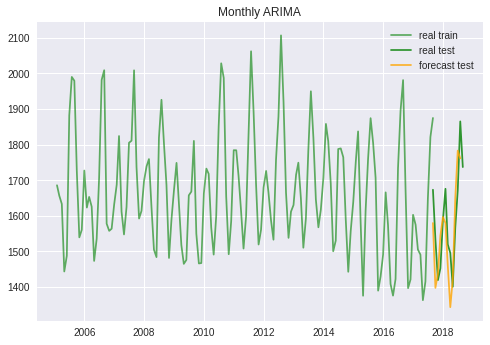

In [ ]:
plt.plot(y_monthly, label='real train', color='green', alpha=0.6)
# plt.plot(y_train.index, pipe.predict(X_train), label='forecast train', color='orange', alpha=0.6)
plt.plot(y_monthly_test, label='real test', color='green', alpha=0.8)
plt.plot(test_ind , y_arima_month, label='forecast test', color='orange', alpha=0.8)
plt.legend();
plt.title('Monthly ARIMA');
plt.show()

In [ ]:
mape = mean_absolute_percentage_error(prep_y(y_arima_month), prep_y(y_monthly_test.loc[test_ind]))
mae = mean_absolute_error(prep_y(y_arima_month), prep_y(y_monthly_test.loc[test_ind]))

print("Test error")
print("\tMAPE = %6.2f"%(mape))
print("\tMAE = %6.2f"%(mae))

Test error
	MAPE =   0.05
	MAE =  81.26


## 3.2 ARIMA weekly data

In [ ]:
y_weekly = df_train[target].resample('w').mean()
y_weekly_test =  df_test[target].resample('w').mean()

In [ ]:
stepwise_model = auto_arima(
    y_weekly, start_p=1, start_q=0,
    max_p=3, max_q=3, m=52,
    start_P=0, seasonal=True,
    d=1, D=1, trace=True,
    error_action='ignore', 
    suppress_warnings=True, 
    stepwise=True
)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
Fit ARIMA(1,1,0)x(0,1,1,52) [intercept=True]; AIC=7545.749, BIC=7563.369, Time=29.367 seconds
Fit ARIMA(0,1,0)x(0,1,0,52) [intercept=True]; AIC=7878.070, BIC=7886.880, Time=2.209 seconds
Fit ARIMA(1,1,0)x(1,1,0,52) [intercept=True]; AIC=7655.838, BIC=7673.459, Time=24.678 seconds
Fit ARIMA(0,1,1)x(0,1,1,52) [intercept=True]; AIC=7445.841, BIC=7463.461, Time=28.423 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 52); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.996)
Fit ARIMA(0,1,0)x(0,1,0,52) [intercept=False]; AIC=7876.078, BIC=7880.483, Time=1.787 seconds
Fit ARIMA(1,1,0)x(0,1,0,52) [intercept=True]; AIC=7784.623, BIC=7797.838, Time=1.433 seconds
Fit ARIMA(1,1,0)x(1,1,1,52) [intercept=True]; AIC=7547.501, BIC=7569.527, Time=63.819 seconds
Near non-invertible roots for order (1, 1, 0)(1, 1, 1, 52); setting score to inf (at least one inverse root too close to the border of the uni

In [ ]:
stepwise_model.fit(y_weekly)

In [ ]:
y_arima_week = stepwise_model.predict(n_periods=52)

In [ ]:
test_ind = pd.date_range(y_weekly.index.max(), freq='w', periods=52)

In [ ]:
plt.plot(y_weekly, label='real train', color='green', alpha=0.6)
plt.plot(y_weekly_test, label='real test', color='green', alpha=0.8)
plt.plot(test_ind, y_arima_week, label='forecast test', color='orange', alpha=0.8)
plt.legend();
plt.title('Weekly ARIMA');
plt.show()

In [ ]:
mape = mean_absolute_percentage_error(prep_y(y_arima_week), prep_y(y_weekly_test.loc[test_ind]))
mae = mean_absolute_error(prep_y(y_arima_week), prep_y(y_weekly_test.loc[test_ind]))

print("Test error")
print("\tMAPE = %6.2f"%(mape))
print("\tMAE = %6.2f"%(mae))

##  3.3 Hourly data

In [ ]:
y_hourly = df_train[target].resample('h').mean()
y_hourly_test =  df_test[target].resample('h').mean()

    
fill_nan_ma = y_hourly.rolling(window=3, center=True, min_periods=1).mean()
indx_na = y_hourly.isna()['DUQ_MW'].values
fill_nan_ma = fill_nan_ma.loc[indx_na, 'DUQ_MW'].values
y_hourly.loc[indx_na, 'DUQ_MW'] = fill_nan_ma

date_start = y_hourly.index.max() - pd.Timedelta('90d')
y_hourly = y_hourly.loc[y_hourly.index > date_start]

date_end = y_hourly_test.index.min() + pd.Timedelta('30d')
y_hourly_test = y_hourly_test.loc[y_hourly_test.index < date_end]

In [ ]:
stepwise_model = auto_arima(
    y_hourly, start_p=1, start_q=0,
    max_p=3, max_q=3, m=24,
    start_P=0, seasonal=True,
    d=1, D=1, trace=True,
    error_action='ignore', 
    suppress_warnings=True, 
    stepwise=True
)
print(stepwise_model.aic())

In [ ]:
stepwise_model.fit(y_hourly)
y_arima_hour = stepwise_model.predict(n_periods=30*24)

In [ ]:
plt.plot(y_hourly, label='real train', color='green', alpha=0.6)
plt.plot(y_hourly_test, label='real test', color='green', alpha=0.8)
plt.plot(y_hourly_test.index, y_arima_hour, label='forecast test', color='orange', alpha=0.8)
plt.legend();
plt.title('ARIMA trained on 90 days of hourly data d=1');
plt.show()

In [ ]:
mape = mean_absolute_percentage_error(prep_y(y_hourly_test), prep_y(y_arima_hour))
mae = mean_absolute_error(prep_y(y_hourly_test), prep_y(y_arima_hour))

print("Test error")
print("\tMAPE = %6.2f"%(mape))
print("\tMAE = %6.2f"%(mae))

In [ ]:
stepwise_model = auto_arima(
    y_weekly, start_p=1, start_q=0,
    max_p=3, max_q=3, m=24,
    start_P=0, seasonal=True,
    d=0, D=1, trace=True,
    error_action='ignore', 
    suppress_warnings=True, 
    stepwise=True
)
print(stepwise_model.aic())

In [ ]:
stepwise_model.fit(y_weekly)
y_arima_hour = stepwise_model.predict(n_periods=30*24)

In [ ]:
plt.plot(y_hourly, label='real train', color='green', alpha=0.6)
# plt.plot(y_train.index, pipe.predict(X_train), label='forecast train', color='orange', alpha=0.6)
plt.plot(y_hourly_test, label='real test', color='green', alpha=0.8)
plt.plot(y_hourly_test.index, y_arima_hour, label='forecast test', color='orange', alpha=0.8)
plt.legend();
plt.title('ARIMA trained on 90 days of hourly data d=0');
plt.show()

In [ ]:
mse = mean_squared_error(prep_y(y_hourly_test), prep_y(y_arima_hour))
mae = mean_absolute_error(prep_y(y_hourly_test), prep_y(y_arima_hour))

print("Test error")
print("\tMSE = %6.2f"%(mse))
print("\tMSE = %6.2f"%(mae))

As it could be seen for high frequency data with a lot-of different seasonalities ARIMA is not the best choice.
While for lower frequencies it is good enought and easy to use - auto determination of ARIME orders works good in this case.